# <a id='toc1_'></a>[**COVIDCast: ARIMA, SARIMA, SARIMAX Modeling and Forecasting**](#toc0_)

Sam Celarek   
Data Science   
scelarek@gmail.com   
August 4th, 2023  



**Table of contents**<a id='toc0_'></a>    
- [**COVIDCast: ARIMA, SARIMA, SARIMAX Modeling and Forecasting**](#toc1_)    
  - [Introduction to the ARIMA, SARIMA, SARIMAX Time Series Models](#toc1_1_)    
  - [Steps for Modeling with ARIMA, SARIMA, SARIMAX](#toc1_2_)    
- [Setup](#toc2_)    
    - [Variables Instantiation](#toc2_1_1_)    
    - [Functions for ARIMA modeling](#toc2_1_2_)    
- [Focused Analysis](#toc3_)    
    - [Visualizing the Data](#toc3_1_1_)    
    - [Checking Stationarity](#toc3_1_2_)    
    - [BoxCox Transformation and Normality Test](#toc3_1_3_)    
    - [Seasonality](#toc3_1_4_)    
    - [ACF and PACF plots](#toc3_1_5_)    
    - [Time Series Cross-Validation Setup](#toc3_1_6_)    
- [Modeling](#toc4_)    
  - [ARIMA](#toc4_1_)    
    - [Base Arima Model](#toc4_1_1_)    
    - [Tuned Arima Model](#toc4_1_2_)    
  - [SARIMA](#toc4_2_)    
    - [Base SARIMA Model](#toc4_2_1_)    
    - [Tuned SARIMA Model](#toc4_2_2_)    
  - [Sarimax](#toc4_3_)    
    - [**Selection of Exogenous variables:**](#toc4_3_1_)    
    - [Base Sarimax Model](#toc4_3_2_)    
    - [Auto-Tuned SARIMAX Model](#toc4_3_3_)    
    - [Brute Force Grid Search for SARIMAX Model](#toc4_3_4_)    
  - [Final Sarimax Modeling](#toc4_4_)    
  - [Final Results and Evaluation](#toc4_5_)    
- [Best COVID Forecaster](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


## <a id='toc1_1_'></a>[Introduction to the ARIMA, SARIMA, SARIMAX Time Series Models](#toc0_)

ARIMA, SARIMA, and SARIMAX are statistical models used for time series analysis and forecasting. These models are particularly adept at capturing linear relationships, trends, and seasonal patterns in time series data.

 - ARIMA (AutoRegressive Integrated Moving Average) is suited for non-seasonal time series data.
 - SARIMA (Seasonal ARIMA) extends ARIMA by adding seasonality components, making it apt for seasonal time series data.
 - SARIMAX (Seasonal ARIMA with eXogenous variables) is a further extension of SARIMA that includes the impact of external or exogenous factors.

These models have a specific structure that is defined by three parameters (p, d, q) in ARIMA and an additional set of four parameters for SARIMA/SARIMAX (P, D, Q) [m]. These parameters are defined as follows:

 - **p** is the number of autoregressive terms (lags of the dependent variable).
 - **d** is the number of nonseasonal differences needed for stationarity.
 - **q** is the number of lagged forecast errors in the prediction equation.
 - **P** is the number of seasonal autoregressive terms.
 - **D** is the number of seasonal differences.
 - **Q** is the number of seasonal moving average terms.
 - **m** is the number of time steps for a single seasonal period.


## <a id='toc1_2_'></a>[Steps for Modeling with ARIMA, SARIMA, SARIMAX](#toc0_)

1. **Parameter/Variable Selection**: Identify the optimal parameters for the ARIMA/SARIMA/SARIMAX model. This is often done through methods like the AIC, BIC or through auto-ARIMA procedures.
2. **Model Fitting**: Fit the model using the chosen parameters and assess the residuals to ensure no patterns are missed.
3. **Model Visual Evaluation:** Assess the model's performance using visual diagnostics.
   -  This includes in-sample and out-of-sample prediction evaluation (a), cross-validation (b), and component analysis (c).
4. **Model Statistical Evaluation:** Assess the model's performance using common error metrics for time series analysis.


# <a id='toc2_'></a>[Setup](#toc0_)

In [1]:
# Import necessary functions from the 'capstone_functions' module
from capstone_functions import *

# Set the plotting style to 'seaborn' for better visualization
plt.style.use('seaborn')

# Suppress any warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set a fixed random seed for reproducibility of results
np.random.seed(42)



Versions used in this notebook:
Python version: 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.0.2
Numpy version: 1.23.4
Seaborn version: 0.12.2
Matplotlib version: 3.7.1
Scipy version: 1.10.1
Statsmodels version: 0.14.0
SKLearn version: 1.2.2


C:\Users\Samsickle\AppData\Local\Temp\ipykernel_37224\2280942363.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Built-in libraries
from IPython.display import display, Markdown, HTML

# Matplotlib
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Prophet
from prophet.plot import plot_cross_validation_metric, plot_plotly
from prophet.diagnostics import cross_validation, performance_metrics

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Other libraries
import scipy.stats as stats
import itertools


In [3]:
# Read the parquet file and store its contents in the 'master_df' DataFrame
master_df = pd.read_parquet("../Data/master_df.parquet")

# Display basic information about the DataFrame (e.g., column data types, non-null values, etc.)
master_df.info()

# Display the first five rows of the DataFrame to get a quick overview
master_df.tail()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1131 entries, 2020-02-15 to 2023-03-21
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   new_confirmed                         1131 non-null   int32  
 1   new_hospitalized_patients             944 non-null    float64
 2   current_hospitalized_patients         1131 non-null   float64
 3   current_intensive_care_patients       1131 non-null   float64
 4   new_fatal                             1131 non-null   int32  
 5   average_temperature_celsius           943 non-null    float64
 6   cancel_events                         1131 non-null   float32
 7   confirmed                             1131 non-null   int32  
 8   cumulative_hospitalized_patients      944 non-null    float64
 9   derived_reproduction_rate             1131 non-null   float64
 10  dew_point                             943 non-null    float64
 11 

new_confirmed  new_hospitalized_patients  \
date                                                   
2023-03-17          18756                        NaN   
2023-03-18           1175                        NaN   
2023-03-19           1424                        NaN   
2023-03-20           9787                        NaN   
2023-03-21          18373                        NaN   

            current_hospitalized_patients  current_intensive_care_patients  \
date                                                                         
2023-03-17                        16437.0                           2110.0   
2023-03-18                        16056.0                           2067.0   
2023-03-19                        16158.0                           2091.0   
2023-03-20                        16555.0                           2179.0   
2023-03-21                        16301.0                           2189.0   

            new_fatal  average_temperature_celsius  cancel_events  confirmed  \
date                                                                           
2023-03-17        363                          NaN            0.0  103782317   
2023-03-18          2                          NaN            0.0  103783492   
2023-03-19          0                          NaN            0.0  103784916   
2023-03-20        138                          NaN            0.0  103794703   
2023-03-21        213                          NaN            0.0  103813076   

            cumulative_hospitalized_patients  derived_reproduction_rate  ...  \
date                                                                     ...   
2023-03-17                               NaN                   1.170246  ...   
2023-03-18                               NaN                   1.170246  ...   
2023-03-19                               NaN                   1.170246  ...   
2023-03-20                               NaN                   1.170246  ...   
2023-03-21                               NaN                   1.170246  ...   

            transport_closing  vaccination_policy  workplace_closing  \
date                                                                   
2023-03-17                0.0                 NaN                1.0   
2023-03-18                0.0                 NaN                1.0   
2023-03-19                0.0                 NaN                1.0   
2023-03-20                0.0                 NaN                1.0   
2023-03-21                0.0                 NaN                1.0   

            dayofweek  quarter  month  year  dayofyear  dayofmonth  \
date                                                                 
2023-03-17          4        1      3  2023         76          17   
2023-03-18          5        1      3  2023         77          18   
2023-03-19          6        1      3  2023         78          19   
2023-03-20          0        1      3  2023         79          20   
2023-03-21          1        1      3  2023         80          21   

            new_bi_weekly_vaccinations  
date                                    
2023-03-17                    824426.0  
2023-03-18                    773329.0  
2023-03-19                    755935.0  
2023-03-20                    799475.0  
2023-03-21                    792508.0  

[5 rows x 66 columns]

### <a id='toc2_1_1_'></a>[Variables Instantiation](#toc0_)

These Variables *must* be set for some of the code to run properly. Please set them appropriately for whichever metric you are running.

In [4]:
# CROSS VALIDATION REQUIRED VALUES
# Define the prediction horizon: how many days in the future we want to forecast
cutoff_period_prediction = 16

# Define the warmup period for the model, typically the initial days where no prediction is made to let the model adjust
initial_warmup_period = 366

# Calculate the date where the training data ends and the test data begins
cutoff_date = master_df.index.max() - pd.Timedelta(days=cutoff_period_prediction)

# Date to forecast from
choose_your_date = cutoff_date



In [5]:
# Drop columns that have any null values to ensure completeness of the dataset
no_null_col = master_df.dropna(axis=1).copy()

# Split the data into training set (all data up to the cutoff_date) and test set (all data after the cutoff_date)
train_df = no_null_col[no_null_col.index < cutoff_date].copy()
train_df.name ='new_confirmed'

test_df = no_null_col[no_null_col.index >= cutoff_date].copy()

# Print out the shapes and the cutoff date for better understanding of the data
print(f"Shape of the dataset after dropping columns with null values: {no_null_col.shape}")
print(f"Cutoff date for training and testing split: {cutoff_date}")
print(f"Shape of the training dataset: {train_df.shape}")
print(f"Shape of the testing dataset: {test_df.shape}")


Shape of the dataset after dropping columns with null values: (1131, 44)
Cutoff date for training and testing split: 2023-03-05 00:00:00
Shape of the training dataset: (1114, 44)
Shape of the testing dataset: (17, 44)


In [6]:
# Splitting the 'ds' (date) and 'new_confirmed' (target variable) from the training and testing datasets for Prophet
y_train = train_df['new_confirmed'].copy()
y_train.name = 'new_confirmed'

y_test = test_df['new_confirmed'].copy()



# Extracting all other features (excluding 'ds' and 'y') from the training and testing datasets
X_train = train_df.drop(columns=['new_confirmed']).copy()
X_test = test_df.drop(columns=['new_confirmed']).copy()

# Print the shapes
print(f"Shape of the y_train dataframe (target variable for training): {y_train.shape}")
print(f"Shape of the y_test dataframe (target variable for testing): {y_test.shape}")
print(f"Shape of the X_train dataframe (features for training): {X_train.shape}")
print(f"Shape of the X_test dataframe (features for testing): {X_test.shape}")



Shape of the y_train dataframe (target variable for training): (1114,)
Shape of the y_test dataframe (target variable for testing): (17,)
Shape of the X_train dataframe (features for training): (1114, 43)
Shape of the X_test dataframe (features for testing): (17, 43)


In [7]:
# all variables
all_variables = train_df.drop(columns=['new_confirmed']).columns.tolist()

# Collinear variables
colinear_variables = ['confirmed', 'susceptible', 'recovered', 'total_removed', 'new_recovered', 'new_susceptible'] # infected?

Not_Colin = list(set(all_variables) - set(colinear_variables))

# Columns related to target variables
target_variables = ['new_confirmed']

# Define a list of most important features based on prior knowledge or feature importance from another model
prior_assumption = ['stringency_index', 'derived_reproduction_rate', 'new_bi_weekly_vaccinations', 
                'current_hospitalized_patients', 'new_fatal'] # mortality_rate


# Define a list of somewhat important features based on prior knowledge or feature importance from another model
somewhat_important =  ['month', 'total_vaccinations', 'dayofmonth', 'stringency_index', 
                    'excess_mortality_cumulative', 'current_intensive_care_patients',
                    'current_hospitalized_patients', 'derived_reproduction_rate',
                    'gatherings_restrictions', 'cancel_events', 't/s_recovery_period',
                    'new_bi_weekly_vaccinations', 'excess_mortality', 'testing_policy',
                    'international_movement_restrictions', 'stay_home_restrictions',
                    'quarter', 'kap_mortality_rate', 'workplace_closing',
                    'internal_movement_restrictions', 'information_campaigns',
                    'transport_closing', 'school_closing', 'rho_transmission_rate',
                    'new_vaccinations', 'sig_recovery_rate', 't/r_infection_period',
                    'new_fatal', 't/k_mortality_period', 'dayofweek']

# Define a list of exploratory variables that might be considered for model enhancements or fine-tuning
frequently_removed_variables =  list(set(train_df.columns) - set(['new_confirmed',
                        'confirmed', 'susceptible', 'fatal', 'infected', # removed 4
                        'excess_mortality', 'total_removed', 'dayofmonth', # removed 7
                        'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute', 'people_fully_vaccinated', 'people_vaccinated', #removed 11
                        # 'transport_closing', 'workplace_closing', 'dayofweek', 'quarter', # removed 15
                        # 'derived_reproduction_rate', 'cancel_events', 'gatherings_restrictions',  
                        # 'information_campaigns', 'internal_movement_restrictions', # removed 20
                        # 't/k_mortality_period', 't/r_infection_period', 't/s_recovery_period', # removed 23
                        'new_recovered', 'new_susceptible', 'recovered', # removing colinear variables
                        # 'sig_recovery_rate', 'rho_transmission_rate', 'kap_mortality_rate', # removed 26
                        # 'new_fatal', 'school_closing', # removed 28
                        ]))

# Variables related to the SIRD model parameters and characteristics
sird_variables = ['rho_transmission_rate', 'sig_recovery_rate', 'derived_reproduction_rate', 
                'kap_mortality_rate', 't/k_mortality_period', 't/r_infection_period', 
                't/s_recovery_period']

# Variables related to date components
date_variables = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth']

# Variables related to restrictions and governmental measures
restriction_variables = ['stay_home_restrictions', 'gatherings_restrictions', 
                        'internal_movement_restrictions', 'international_movement_restrictions',  
                        'cancel_events', 'school_closing', 'transport_closing', 'workplace_closing', 
                        'testing_policy', 'stringency_index', 'information_campaigns']

# Variables related to the epidemiological data and progress of the disease
epidemiological_variables = ['fatal', 'excess_mortality',  
                            'new_fatal', 
                            'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute',
                            'new_vaccinations', 'people_fully_vaccinated', 'people_vaccinated', 
                            'new_bi_weekly_vaccinations', 'total_vaccinations',
                            'current_hospitalized_patients', 'current_intensive_care_patients']


In [8]:

# Initialize dataframes to hold evaluation metrics for validation, in-sample, and out-of-sample predictions
val_eval_holder = pd.DataFrame().rename_axis('Validation Metric', axis=1)
in_sample_eval_holder = pd.DataFrame().rename_axis('In-Sample Metric', axis=1)
out_of_sample_eval_holder = pd.DataFrame()



In [9]:
# What type of code test do you want to run?
# If all false, takes about 10minutes to run
training = True # Only way to get cross validation scores -- Takes about 30minutes to run
searching = True # Demonstrates Search with AutoARIMA -- Takes about 1 hr to run

# Brute Force Search -- Takes about 2 hours to run and requires you to go to those sections of the notebook and uncomment the code

### <a id='toc2_1_2_'></a>[Functions for ARIMA modeling](#toc0_)

In [10]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value','Number of Observations Used'])
    return dfoutput


def test_stationarity(timeseries, plot=True):
    """
    Test the stationarity of a given time series.
    
    This function plots the original time series along with its rolling mean 
    and rolling standard deviation. It then performs the Dickey-Fuller test 
    to statistically test the stationarity of the series.
    
    Parameters:
    - timeseries (pd.Series): The time series data to test for stationarity.
    
    Returns:
    None. However, it displays the plot and prints the results of the Dickey-Fuller test.
    """
    
    # Calculate rolling statistics with a window of 12
    rolmean = timeseries.rolling(window=12).mean()  # Rolling mean
    rolstd = timeseries.rolling(window=12).std()    # Rolling standard deviation

    if plot:
        # Initialize a plotly graph with a secondary y-axis for displaying the rolling std deviation
        fig = make_subplots(specs=[[{"secondary_y": True}]])

        # Plot the original series
        fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, mode='lines', name='Original', line=dict(color='blue')))
        
        # Plot the rolling mean
        fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean, mode='lines', name='Rolling Mean', line=dict(color='red')))
        
        # Plot the rolling standard deviation on the secondary y-axis
        fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd, mode='lines', name='Rolling Std', line=dict(color='black')), secondary_y=True)

        # Customize the layout of the plot
        fig.update_layout(title='Rolling Mean & Standard Deviation',
                        xaxis_title='Date',
                        yaxis_title='Value',
                        yaxis2_title='Rolling Std Deviation',
                        xaxis=dict(rangeslider=dict(visible=True), type='date'),
                        xaxis_rangeslider_visible=True)

        # Display the visual representation of the series, rolling mean, and std deviation
        fig.show()

    # Perform the Dickey-Fuller test to test the stationarity of the series
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Display the results of the Dickey-Fuller test
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    display(dfoutput)



In [11]:
def plot_cross_val(df: pd.DataFrame,
                    title_text: str,
                    fold_size: int,
                    adjustment: int,
                    rolling: bool=False,
                    window_size: int=366,
                    initial_size: int=366) -> pd.DataFrame:
    """
    Visualize the train and test splits of cross-validation using Plotly.
    
    This function generates a visual representation of how data is split into 
    training and testing sets across multiple iterations of a cross-validation 
    process. It's particularly useful for understanding the behavior of different 
    cross-validation strategies, such as KFold or TimeSeriesSplit.
    
    Parameters:
    - n_splits (int): Number of splits for cross-validation.
    - splitter_func (callable): Cross-validation splitting strategy (e.g., KFold, TimeSeriesSplit).
    - df (pd.DataFrame): Dataframe whose index is to be used for splitting.
    - title_text (str): Title of the plot.
    
    Returns:
    - plot_df (pd.DataFrame): DataFrame with indices used for each split and their corresponding labels.
    """
    
    split = 1
    plot_data = []

    if rolling:
    # Iterate through train and test splits provided by the splitter function
    
        window_cv = RollingForecastCV(
            h=fold_size,            # Forecast horizon (28 step ahead)
            step=fold_size+adjustment,         # Step size for rolling window (28 step at a time)
            initial=initial_size)   # Skip the first 20 observations for warm-up
        for train_index, valid_index in window_cv.split(df):
            plot_data.append([train_index, 'Train', f'{split}'])
            plot_data.append([valid_index, 'Test', f'{split}'])
            split += 1
    else:
        window_cv = pm.model_selection.SlidingWindowForecastCV(
            window_size=window_size,         # Window size (150 observations)
            h=fold_size,             # Forecast horizon (28 step ahead)
            step=fold_size+adjustment)          # Step size for rolling window (28 step at a time)
        # Iterate through train and test splits provided by the splitter function
        
        for train_index, valid_index in window_cv.split(df):
            plot_data.append([train_index, 'Train', f'{split}'])
            plot_data.append([valid_index, 'Test', f'{split}'])
            split += 1
    
    # Create a DataFrame to hold the indices for plotting
    plot_df = pd.DataFrame(plot_data, columns=['Index', 'Dataset', 'Split']).explode('Index')
    plot_df['Split'] = plot_df['Split'].astype(int)
    plot_df = plot_df.sort_values('Split')

    # Initialize a Plotly figure
    fig = go.Figure()

    # Add traces for each train and test split
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                y=group['Split'].loc[group['Dataset'] == 'Train'],
                                name='Train',
                                line=dict(color="blue", width=10)
                                ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                y=group['Split'].loc[group['Dataset'] == 'Test'],
                                name='Test',
                                line=dict(color="goldenrod", width=10)
                                ))

    # Configure plot layout
    fig.update_layout(template="simple_white", 
                    font=dict(size=20),
                    title_text=title_text, 
                    title_x=0.5, width=850,
                    height=450, 
                    xaxis_title='Index', 
                    yaxis_title='Split')

    # Update legend to avoid duplicate entries
    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))
    fig.show()
    

In [12]:

# Format right y-axis with comma notation
def comma_format(x, _):
    return f'{x:,.0f}'

def mape(actual, pred):
    return 100 * np.mean(np.abs(actual - pred) / (np.abs(actual+1)))

def smape(actual, pred):
    return 100 * np.mean(np.abs(actual - pred) / (np.abs(actual) + np.abs(pred)))

def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))


In [13]:
def train_model(y: pd.Series, pipeline, cv, X: pd.DataFrame=None):
    """
    Train a model on the given data and generate predictions.
    
    Parameters:
    - y: DataFrame containing the training data.
    - pipeline: Preprocessing pipeline for the data.
    - cv: Cross-validator for time series data.
    
    Returns:
    - model_preds: Series of model predictions.
    - model_scores: DataFrame containing the scores for various metrics.
    """
    model_preds_data = {
        'predicted': [],  # predicted values
        'lower_conf': [], # lower confidence interval
        'upper_conf': [], # upper confidence interval
        'date': [] # date of prediction
    }
    
    # model_mape_score = pd.Series(name='mape')
    model_smape_score = pd.Series(name='smape')
    model_rmse_score = pd.Series(name='rmse')
    model_mae_score = pd.Series(name='mae')
    
    for train_idx, test_idx in tqdm(cv.split(y)):
        train_set = y.iloc[train_idx]
        test_set = y.iloc[test_idx]
        
        train_exogenous = X.iloc[train_idx] if X is not None else None
        test_exogenous = X.iloc[test_idx] if X is not None else None
        
        # assert not train_set.isna().any(), "train_set contains NaN values"
        # assert not test_set.isna().any(), "test_set contains NaN values"
        
        model = pipeline.fit(train_set, train_exogenous)
        
        try:
            prediction, conf = model.predict(len(test_set), test_exogenous, return_conf_int= True)
        except:
            prediction = model.predict(len(test_set), test_exogenous)
            conf = np.full(shape=(len(test_set), 2), fill_value=prediction)
        lower_conf = conf[:,0]
        upper_conf = conf[:,1]
            
        model_preds_data['predicted'].extend(prediction)
        model_preds_data['lower_conf'].extend(lower_conf)
        model_preds_data['upper_conf'].extend(upper_conf)
        model_preds_data['date'].extend(test_set.index)
        
        first_date = test_set.index[0]
        model_smape_score[first_date] = smape(test_set, prediction)
        model_rmse_score[first_date] = rmse(test_set, prediction)
        model_mae_score[first_date] = np.mean(np.abs(test_set - prediction))
        # model_mape_score[first_date] = mape(test_set, prediction)
    
    # Generating Daily Metrics
    daily_metrics = pd.DataFrame(model_preds_data)
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    daily_metrics.set_index('date', inplace=True)
    daily_metrics = pd.concat([daily_metrics, y], axis=1, join='outer')
    daily_metrics['residual'] = daily_metrics[y.name] - daily_metrics['predicted']
    daily_metrics['smape'] =  100 * np.abs(daily_metrics[y.name] - daily_metrics['predicted']) / (np.abs(daily_metrics[y.name]) + np.abs(daily_metrics['predicted']))

    
    # Generating Model Scores on Validation Sets
    model_scores = pd.DataFrame(
        index=['MAE', 'RMSE', 'sMAPE'], 
        data=[model_mae_score, model_rmse_score, model_smape_score]
    ).T

    # Fitting the Model on the Entire Dataset
    model = pipeline.fit(y)

    return daily_metrics, model_scores, model



In [14]:
def plot_combined_charts(daily_df: pd.DataFrame, validation_scores_df: pd.DataFrame, target_column: str) -> None:
    """
    Plot actual vs predicted values and evaluation metrics side by side.
    
    This function visualizes the actual vs predicted values and evaluation metrics 
    (MAPE, SMAPE, MAE, RMSE) side by side in a 1x2 grid.
    
    Parameters:
    - daily_df (pd.DataFrame): A dataframe containing the actual and predicted values.
    - validation_scores_df (pd.DataFrame): A dataframe with columns 'mape', 'smape', 'mae', and 'rmse'.
    - target_column (str): The name of the target column for which predictions are made.
    
    Returns:
    None. The function displays the plots.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot Actual vs Predicted on the first axis
    daily_df[f'{target_column}'].plot(ax=ax1, label='Actual', linewidth=2)
    daily_df['predicted'].plot(ax=ax1, label='Cross-Validation Predicted', linestyle='--', linewidth=2)
    ax1.yaxis.set_major_formatter(FuncFormatter(comma_format))
    ax1.set_title(f'Cross Validation of {target_column.replace("_", " ").capitalize()}: Model Predictions vs Actual Data', fontsize=14)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # Plot Error Metrics on the second axis
    sns.lineplot(x=validation_scores_df.index, y=validation_scores_df['MAE'], ax=ax2, label='MAE', color='b')
    sns.lineplot(x=validation_scores_df.index, y=validation_scores_df['RMSE'], ax=ax2, label='RMSE', color='g')
    
    ax3 = ax2.twinx()
    sns.lineplot(x=validation_scores_df.index, y=validation_scores_df['sMAPE'], ax=ax3, label='sMAPE', color='purple', linestyle='--')
    ax2.set_ylabel('Absolute Error (Covid Cases)')
    ax3.set_ylabel('Percentage Error (Covid Cases)')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x/100)))
    ax3.set_ylim(0, 100)
    ax2.set_title('Cross-Validation Error Metrics: Error over Different Time Periods', fontsize=14)
    ax2.set_xlabel('Date')
    
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles3, labels3 = ax3.get_legend_handles_labels()
    ax2.legend(handles=handles2 + handles3, labels=labels2 + labels3, loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [15]:
def plot_predictions_with_confidence_interval(train_df, model, X_train=None):
    """
    Plot actual versus predicted values along with the 95% confidence interval.
    
    This function takes the actual in-sample set and a fitted model to generate a plot
    showcasing the actual values, predicted values, and the confidence interval. It then
    calculates and returns evaluation metrics in a DataFrame.
    
    Parameters:
    - train_df (pd.Series): The actual values.
    - model: The fitted model.
    
    Returns:
    pd.DataFrame: A dataframe containing evaluation metrics.
    """
    
# Predict in-sample values and get confidence intervals
    predicted_values, conf_int = model.predict_in_sample(X=X_train, return_conf_int=True, start=initial_warmup_period)
    
    
    train_df = train_df.iloc[initial_warmup_period:]

    # Adjust the index to match the length of predicted_values
    adjusted_index = train_df.index[-len(predicted_values):]

    # Convert predicted_values into a DataFrame
    predicted_df = pd.DataFrame(predicted_values, columns=['predicted'], index=adjusted_index)

    # Merge the train_df with the predicted_df
    merged_df = pd.merge(train_df, predicted_df, left_index=True, right_index=True)

    # Calculate residuals
    residuals = merged_df['new_confirmed'] - merged_df['predicted']

    # Replace the residuals in your DataFrame creation:
    df = pd.DataFrame(data={
        'predicted_in_sample': predicted_values,
        'upper_conf': conf_int[:, 1],
        'lower_conf': conf_int[:, 0],
        'residuals': residuals
    }, index=adjusted_index)
    
    
    # Initialize a Plotly figure for visualization
    # Initialize a Plotly figure for visualization
    fig = go.Figure()

    # Add traces for actual and predicted values, as well as confidence intervals
    fig.add_trace(go.Scatter(x=df.index, y=train_df, mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df.index, y=df['predicted_in_sample'], mode='lines', name='Predicted', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=df.index, y=df['upper_conf'], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=0), showlegend=False))
    fig.add_trace(go.Scatter(x=df.index, y=df['lower_conf'], mode='lines', name='95% Confidence Interval', line=dict(color='rgba(255, 0, 0, 0.3)', width=0), fill='tonexty'))

    # Update layout to include range sliders for better interactivity
    fig.update_layout(
        title='In-Sample Data vs. Predicted Values with Confidence Intervals',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=2, label="2y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        ),
        yaxis=dict(
            title="COVID New Case Count",
            rangemode="tozero"
        )
    )

    # Render the figure
    fig.show()

    # # Create the histogram plot for residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(df['residuals'], kde=True, color="dodgerblue", bins=30)
    
    # Set title and labels
    plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
    plt.xlabel('Residuals', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Show the plot with a tight layout
    plt.tight_layout()
    plt.show()

    # Compute evaluation metrics
    adjusted_train_df = train_df.iloc[-len(predicted_values):]
    r2 = r2_score(adjusted_train_df, predicted_values)
    mae = mean_absolute_error(adjusted_train_df, predicted_values)
    rmse = np.sqrt(mean_squared_error(adjusted_train_df, predicted_values))
    smape_val = smape(adjusted_train_df, predicted_values)


    # Create and return a DataFrame with the calculated metrics
    metrics_df = pd.DataFrame({
        'R-squared': [r2],
        'MAE': [mae],
        'RMSE': [rmse],
        'sMAPE': [smape_val]
    })
    
    # Adjust the figure size
    fig2, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot ACF
    plot_acf(df['residuals'].dropna(), lags=40, ax=ax[0], title="Autocorrelation Plot (ACF)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Autocorrelation")
    ax[0].grid(True)
    ax[0].tick_params(axis='both', which='major', labelsize=10)

    # Plot PACF
    plot_pacf(df['residuals'].dropna(), lags=40, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Partial Autocorrelation")
    ax[1].grid(True)
    ax[1].tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()
    
    return metrics_df.T


In [16]:

def evaluate_forecast(train_df, y_test, model, X_test=None):
    """
    Evaluate the performance of an ARIMA forecast against y_test values and visualize the results.
    
    This function computes multiple error metrics including MAE, RMSE, MAPE, and sMAPE. 
    It also visualizes the train_df, y_test, and predicted series for easier comparison 
    using Plotly.
    
    Parameters:
    - train_df (pd.Series): Series containing train_df values leading up to the forecast.
    - y_test (pd.Series): Series containing the y_test values for the time period being forecasted.
    - predicted (pd.Series): Series containing the predicted values from the ARIMA model.
    
    Returns:
    - metrics_df (pd.DataFrame): A DataFrame containing the calculated error metrics.
    """
    predicted, conf = model.predict(len(y_test), X=X_test, return_conf_int= True)
    predicted = pd.Series(predicted, index=y_test.index)
    lower_conf = conf[:,0]
    upper_conf = conf[:,1]    # Calculate daily error metrics
    
    daily_metrics = pd.DataFrame()
    daily_metrics['residual'] = y_test - predicted
    daily_metrics['predicted'] =  predicted
    daily_metrics['y_test'] =  y_test
    daily_metrics['lower_conf'] =  lower_conf
    daily_metrics['upper_conf'] =  upper_conf
    
    
    
    # # Create a seaborn scatter plot
    # fig1 = go.Figure()

    # # Plot mae on the primary y-axis
    # fig1 = px.scatter(daily_metrics, x='predicted', y='residual', title="Predicted Values vs Residuals")
    # fig1.update_layout(title="Predicted Values vs Residuals", xaxis_title="Predicted Values")
    # fig1.update_yaxes(title_text="Residuals")
    # fig1.show()
    
    
    # Create a Plotly visualization to compare train_df, y_test, and predicted series
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(y=train_df[-40:], x=train_df.index[-40:], mode='lines', name='In Sample Set', line=dict(color='blue', width=2)))
    fig2.add_trace(go.Scatter(y=y_test, x=y_test.index, mode='lines', name='Out of Sample Set', line=dict(color='green', width=2)))
    fig2.add_trace(go.Scatter(y=predicted, x=predicted.index, mode='lines', name='Predicted', line=dict(color='red', width=2, dash='dash')))
    
    # Add upper and lower confidence intervals and fill between them
    fig2.add_trace(go.Scatter(x=predicted.index, y=upper_conf, mode='lines', name='Upper Confidence', line=dict(width=0), showlegend=False))
    fig2.add_trace(go.Scatter(x=predicted.index, y=lower_conf, mode='lines', name='Lower Confidence', line=dict(width=0), fill='tonexty', fillcolor='rgba(255,0,0,0.2)', showlegend=False))
    
    # Customize the layout of the plot
    fig2.update_layout(title="Final SARIMAX Model: Actual vs Predicted Values", 
                    xaxis_title="Date", 
                    yaxis_title="Value",
                    xaxis_rangeslider_visible=True,
                    width=950,
                    height=500)
    
    # Display the visualization
    fig2.show()
    
    
    # Calculate error metrics
    mae = mean_absolute_error(y_test, predicted)
    rmse = np.sqrt(mean_squared_error(y_test, predicted))
    smape = np.mean(np.abs(y_test - predicted) / (np.abs(y_test) + np.abs(predicted))) * 100
    # mape = np.mean(np.abs(y_test - predicted) / (np.abs(y_test+1))) * 100
    
    
    # Return the computed metrics in a DataFrame for further analysis or reporting
    metrics_df = pd.DataFrame({
        'Test Metric': ['MAE', 'RMSE', 'sMAPE'],
        'Value': [mae, rmse, smape]
    })
    
    return metrics_df.set_index('Test Metric') #, daily_metrics


In [17]:

def run_analysis(train_df, y_test, pipeline, window_cv, training=True, X_train=None, X_test=None):
    """
    Train a model, plot validation results, evaluate the forecast, and store results.
    
    Parameters:
    - train_df (pd.Series or pd.DataFrame): Time series data for model training.
    - y_test (pd.Series or pd.DataFrame): Time series data for forecasting.
    - pipeline: The model pipeline or configuration.
    - window_cv: Cross-validation window or method.

    Returns:
    - val_scores (pd.DataFrame or pd.Series): Validation scores from the model.
    - arima_result (tuple or dict): Results of the forecast evaluation.
    - model: Trained model.
    """
    if training:
        # If in training mode:
        
        # Train the model using the specified pipeline and cross-validation window
        daily_values, val_scores, model = train_model(train_df, pipeline, window_cv, X_train)

        try:
            print("Almost Done Analyzing", str(model.steps[-1][1]).strip())
        except:
            print("Almost Done Analyzing", model)
        
        # Visualize the model's performance on the validation set
        plot_combined_charts(daily_values, val_scores, train_df.name)

    
    # Visualize the model's in-sample predictions with confidence intervals
    in_sample_scores = plot_predictions_with_confidence_interval(train_df, model, X_train)


    # Evaluate the model's forecasting performance on the out-of-sample data
    test_scores = evaluate_forecast(train_df, y_test, model, X_test)

    # Display the summary of the trained model
    display(model.summary())

    if training:
        return val_scores, in_sample_scores, test_scores, model
    else:
        return in_sample_scores, test_scores, model




In [18]:
def COVIDCastArima(model, choose_your_date, df=master_df, title='SARIMAX', horizon=16, target='new_confirmed', exogenous=None):
    """
    Generates a forecast using the ARIMA model and plots the results.
    
    Parameters:
    ----------
    model : ARIMA model instance or pipeline
        The ARIMA model or pipeline to be used for forecasting.
        
    choose_your_date : pd.Timestamp
        A timestamp representing the start date for the prediction.
    df : pd.DataFrame, default=master_df
        The dataset used for the forecasting.
    title : str, default='SARIMAX'
        A string representing the title for the plots.
    horizon : int, default=16
        The number of days to forecast ahead.
    target : str, default='new_confirmed'
        The column name in the dataframe representing the target variable for forecasting.
    exogenous : list, default=None
        List of columns in the dataframe to be considered as exogenous variables.
        
    Returns:
    -------
    COVIDCast : pd.DataFrame
        A DataFrame containing the forecasted results.
    """
    
    
    ######################## Creating Future Forecast ################################

    # Ensure the dataframe is sorted by date
    # Split data for training and prediction
    start_date = choose_your_date - pd.Timedelta(days=7)
    day3 = choose_your_date + pd.Timedelta(days=3)
    day7 = choose_your_date + pd.Timedelta(days=7)
    day14 = choose_your_date + pd.Timedelta(days=14)
    end_date = choose_your_date + pd.Timedelta(days=horizon-1)
    dates_ls = [day3, day7, day14]

    assert choose_your_date >= df.index.min() + pd.Timedelta(days=366), 'Please choose a date after 2021-02-22'
    assert end_date <= df.index.max(), 'Please choose a date + horizon before 2023-03-22'
    
    
    # Pre-process data
    no_null_col = df.dropna(axis=1)  # Remove columns with null values
    train_df = no_null_col[no_null_col.index < choose_your_date]  # Training data
    test_df = no_null_col[(no_null_col.index >= choose_your_date) & (no_null_col.index <= end_date)]  # Test data
    
    y_train = train_df[target]
    
    if exogenous is not None:
        X_train = train_df[exogenous]
        X_test = test_df[exogenous]
        model.fit(y_train, X_train)
        forecast, conf_int = model.predict(n_periods=horizon, X=X_test.iloc[:horizon, :], return_conf_int=True)
    else:
        model.fit(y_train)
        forecast, conf_int = model.predict(n_periods=horizon, return_conf_int=True)

    # Create future_dates list
    future_dates = [choose_your_date + pd.Timedelta(days=i) for i in range(horizon)]

    # Then proceed to create the DataFrame...
    COVIDCast = pd.DataFrame(index= future_dates, data={
        'yhat': forecast,
        'y': test_df[target],
        'yhat_lower': conf_int[:, 0],
        'yhat_upper': conf_int[:, 1],
        'residuals': test_df[target] - forecast,
        'sMAPE': smape(test_df[target], forecast)
    })
    
    
    ######################## Plotting Line Graph ################################
    fig, ax = plt.subplots(figsize=(14, 7))

    COVIDCast.plot(y='yhat', ax=ax, label='Predicted Values', color='red', linestyle='--')
    df.loc[start_date:choose_your_date,:].plot(y=target, ax=ax, label='Historical Values', color='blue')
    COVIDCast.plot(y='y', ax=ax, label='Real Values', color='green')

    ax.axvline(x=choose_your_date, color='black', linestyle='--', alpha=0.6, label='Today')
    for i in dates_ls:
        ax.axvline(x=i, color='red', linestyle='--', alpha=0.6)

    plt.fill_between(COVIDCast.index, COVIDCast['yhat_lower'], 
                    COVIDCast['yhat_upper'], color='red', 
                    alpha=0.1, label='95% Confidence Interval')

    # Create a secondary x-axis at the top
    ax2 = ax.twiny()

    # Set the xtick labels for day 3, 7, and 14 on the secondary x-axis
    ax2.set_xticks(dates_ls)
    ax2.set_xticklabels(['Day 3', 'Day 7', 'Day 14'])
    ax2.set_xlim(ax.get_xlim())  # Ensure the secondary axis has the same limits as the original axis

    # Set title with larger font and increase y-axis label font size
    plt.title(f'{title} Model COVIDCast for next {horizon} days', fontsize=18)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value', fontsize=16)
    ax.legend()
    plt.tight_layout()
    plt.show()


    ######################## Plotting Heatmap ################################
    # Generate heatmap for days 3, 7, and 14
    microCast = COVIDCast.loc[dates_ls].rename(index={day3: 'Third Day', 
                                                    day7: 'Seventh Day', 
                                                    day14: 'Fourteenth Day'})
    microCast = microCast.rename(columns={'y': 'Actual Values', 
                                        'yhat': 'Predicted Values', 
                                        'yhat_lower': 'Lower 95% CI', 
                                        'yhat_upper': 'Upper 95% CI',
                                        'residuals': 'Error on this Day', 
                                        'sMAPE': 'Average Percent Distance (%)'})

    selected_columns = ['Upper 95% CI', 'Predicted Values', 'Lower 95% CI', 'Actual Values']
    microCast = microCast[selected_columns]

    # Plotting the heatmap
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.set(font_scale=1.2)

    # Use the coolwarm palette
    cmap = "coolwarm"

    sns.heatmap(microCast.T, annot=True, cmap=cmap, linewidths=0.2, fmt=',.0f', cbar=True, 
                annot_kws={"weight": "bold"}, center=microCast.mean().mean(), robust=True)  # Making annotations bold

    # Adjusting the plot appearance
    ax.xaxis.tick_top()  # Move x-axis to the top
    ax.xaxis.set_label_position('top')
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d: %A'))
    plt.xticks(size=12, weight='bold')

    plt.yticks(size=12, weight='bold', rotation=0)
    plt.xlabel('Date', fontsize=16, weight='bold')
    plt.ylabel('Covid Cases Predictions', fontsize=16, weight='bold')
    plt.title(f'{title} Model: COVIDCast for Day 3, 7, 14', fontsize=18, weight='bold')
    plt.tight_layout()
    plt.show()
    
    
    ######################## Creating Scores ####### Only do if you have time or compute to spare!?!?
        

    # window_cv = pm.model_selection.SlidingWindowForecastCV(
    #     window_size=366, # Window size (150 observations)
    #     h=fold_size,  # Forecast horizon (28 step ahead)
    #     step=fold_size+adjustment)  # Step size for rolling window (28 step at a time)
    
    # mae_score = cross_val_score(model, y_train, scoring='mean_absolute_error', cv=window_cv, verbose=1)

    # # Enhanced display using HTML
    # display(HTML(f"""
    # <div style='background-color: #d3d3d3; padding: 20px; border-radius: 5px; text-align: center;'>
    #     <h3>Model's Cross Validation Scores over a 14 day Time Horizon</h3>
    #     <b style='font-size: 18px;'>Mean Absolute Error:</b> 
    #     <span style='font-size: 18px;'>{np.mean(mae_score):,.0f} Covid Cases</span>
    # </div>
    # """))
    
    return COVIDCast


# # Example usage:

# estimators = [
# ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
# ("model", pm.arima.ARIMA(order= (3, 0, 2), 
#                 seasonal_order =(2, 1, 1, 7),
#                 suppress_warnings=True))               
#                 ]

# pipeline = Pipeline(estimators) 


# forecast_df = COVIDCastArima(pipeline, 
#                             choose_your_date=choose_your_date, 
#                             df=master_df, 
#                             horizon=16, 
#                             target='new_confirmed', 
#                             exogenous=most_important)



# <a id='toc3_'></a>[Focused Analysis](#toc0_)



### <a id='toc3_1_1_'></a>[Visualizing the Data](#toc0_)

First, let's visualize the time series data to understand its patterns and trends.


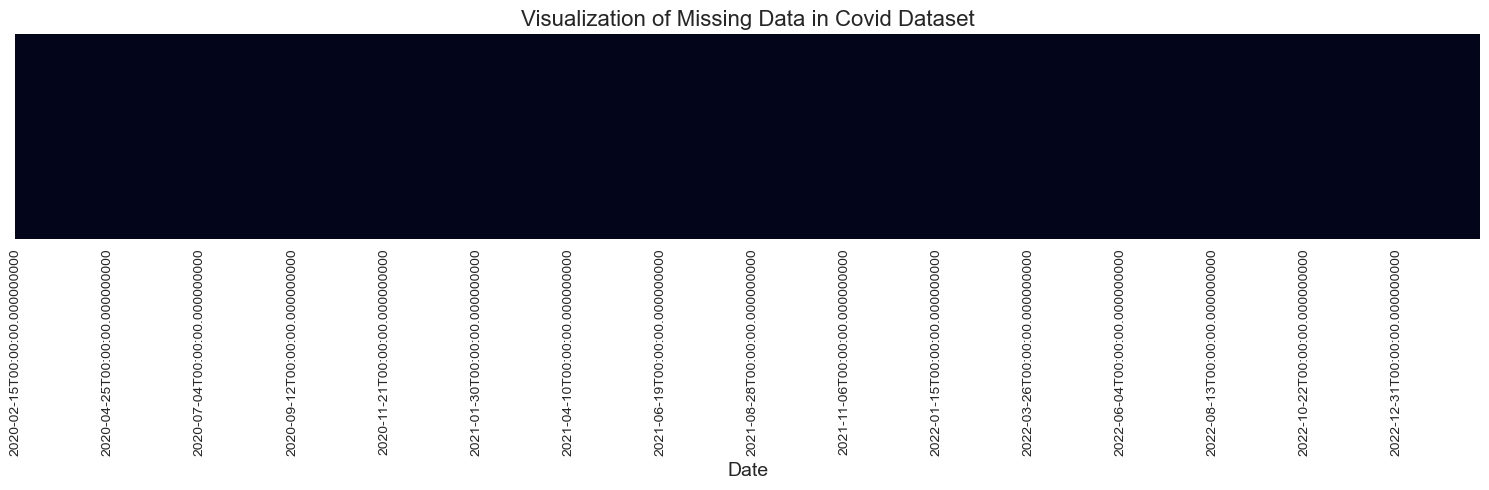

In [19]:
# Your existing code
plt.figure(figsize=(15,5))
sns.heatmap(train_df.isna().T, yticklabels=[], cbar=False)

# Setting x-axis to show every 3 months and starting from 2020-02-15
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticks(xticks[::5])

plt.title("Visualization of Missing Data in Covid Dataset", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
# Creating subplots vertically aligned
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("Daily Confirmed Cases", "Currently Infected", "Total Confirmed"))

# Adding traces for the train dataset
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['new_confirmed'], name='New Confirmed (Train)', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['infected'], name='Currently Infected (Train)', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['confirmed'], name='Total Confirmed (Train)', line=dict(color='blue')), row=3, col=1)

# Adding traces for the test dataset
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['new_confirmed'], name='New Confirmed (Test)', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['infected'], name='Currently Infected (Test)', line=dict(color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['confirmed'], name='Total Confirmed (Test)', line=dict(color='red')), row=3, col=1)

# Update the layout
fig.update_layout(height=800, 
                width=1000, 
                title='Daily Confirmed Cases, Currently Infected, and Total Confirmed',
                xaxis_rangeslider_visible=False)
fig.update_xaxes(title_text='Date', row=3, col=1)
fig.update_yaxes(title_text='New Confirmed Cases', row=1, col=1)
fig.update_yaxes(title_text='Currently Infected', row=2, col=1)
fig.update_yaxes(title_text='Total Confirmed', row=3, col=1)



### <a id='toc3_1_2_'></a>[Checking Stationarity](#toc0_)
Before applying ARIMA or its variants, it's essential to ensure our time series is stationary.


In [21]:

test_stationarity(train_df['confirmed'])

# # Display the collected test statistics for each differencing level
# for i, test_stat in enumerate(test_statistics, 1):
#     print(f"Differencing Level {i}: Test Statistic = {test_stat:.2f}")

Results of Dickey-Fuller Test:


Test Statistic                   -0.006552
p-value                           0.957987
#Lags Used                       22.000000
Number of Observations Used    1091.000000
Critical Value (1%)              -3.436358
Critical Value (5%)              -2.864193
Critical Value (10%)             -2.568182
dtype: float64


If the `p-value` is less than 0.05, the series is stationary. Otherwise, you might need to take differences or transformations to make it stationary.


In [22]:
# List to collect the 'Test Statistic' values for each differencing level
test_statistics = []

# Iterate over possible differencing levels from 1 to 19
for i in range(1, 20):
    # Difference the 'confirmed' series by the current level and drop NA values
    differenced_series = train_df['confirmed'].diff(i).dropna()
    
    # Get the test statistic from the stationarity check and append to the list
    test_stat = check_stationarity(differenced_series).loc['Test Statistic']
    test_statistics.append(test_stat)

# Display the collected test statistics for each differencing level
for i, test_stat in enumerate(test_statistics, 1):
    print(f"Differencing Level {i}: Test Statistic = {test_stat:.2f}")

Differencing Level 1: Test Statistic = -4.79
Differencing Level 2: Test Statistic = -4.44
Differencing Level 3: Test Statistic = -4.39
Differencing Level 4: Test Statistic = -3.62
Differencing Level 5: Test Statistic = -3.86
Differencing Level 6: Test Statistic = -3.55
Differencing Level 7: Test Statistic = -3.48
Differencing Level 8: Test Statistic = -3.13
Differencing Level 9: Test Statistic = -2.92
Differencing Level 10: Test Statistic = -3.14
Differencing Level 11: Test Statistic = -2.94
Differencing Level 12: Test Statistic = -3.31
Differencing Level 13: Test Statistic = -3.93
Differencing Level 14: Test Statistic = -4.10
Differencing Level 15: Test Statistic = -4.45
Differencing Level 16: Test Statistic = -3.54
Differencing Level 17: Test Statistic = -3.61
Differencing Level 18: Test Statistic = -3.64
Differencing Level 19: Test Statistic = -3.67


In [23]:
test_stationarity(train_df['new_confirmed'])


Results of Dickey-Fuller Test:


Test Statistic                   -4.787313
p-value                           0.000058
#Lags Used                       21.000000
Number of Observations Used    1092.000000
Critical Value (1%)              -3.436353
Critical Value (5%)              -2.864190
Critical Value (10%)             -2.568181
dtype: float64

### <a id='toc3_1_3_'></a>[BoxCox Transformation and Normality Test](#toc0_)

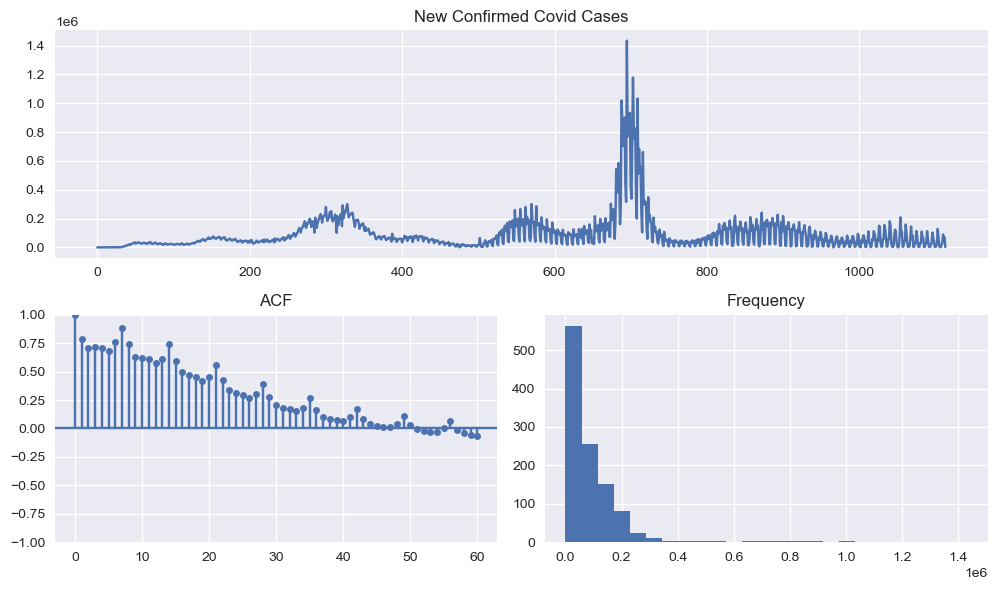

In [24]:
# sns.histplot(data = train_df, x='new_confirmed', bins=100, kde=True);

pm.tsdisplay(train_df['new_confirmed'], title="New Confirmed Covid Cases", lag_max=60, figsize=(10, 6));


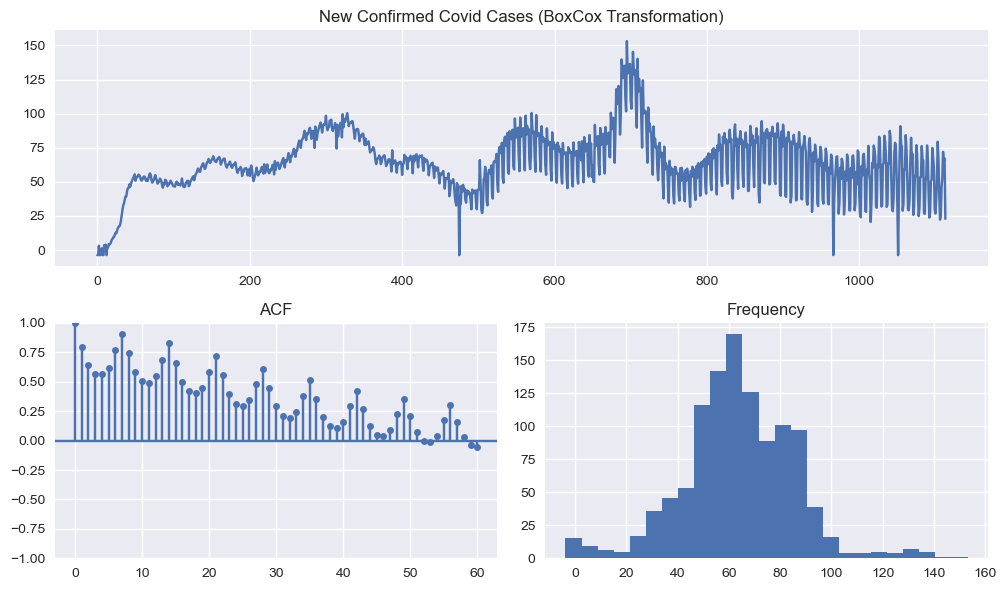

In [25]:
boxcox = BoxCoxEndogTransformer(lmbda2=1e-6)
covid_array = boxcox.fit_transform(train_df['new_confirmed'])[0]
covid_transformed = pd.Series(covid_array, index=train_df.index)

pm.tsdisplay(covid_transformed, title="New Confirmed Covid Cases (BoxCox Transformation)", lag_max=60, figsize=(10, 6))


### <a id='toc3_1_4_'></a>[Seasonality](#toc0_)

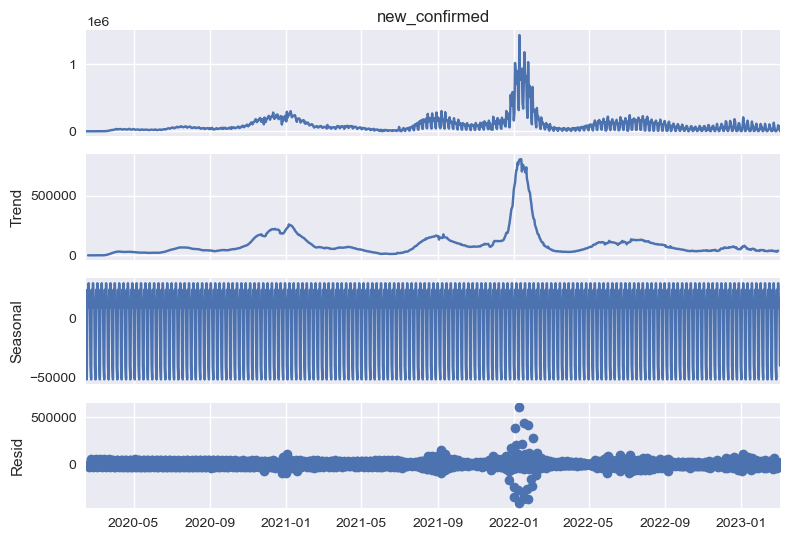

In [26]:
# Performing seasonal decomposition on 'new_confirmed' column
tsa.seasonal_decompose(train_df['new_confirmed'], model='additive', period=7).plot();


This is a little difficult for me to understand, except to say that there really doesn't appear to be much of a seasonal component.

In [27]:
features, target = create_features(train_df, label='new_confirmed')
features_and_target = pd.concat([features, target], axis=1)

features_and_target.head()

hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
date                                                                       
2020-02-15     0          5        1      2  2020         46          15   
2020-02-16     0          6        1      2  2020         47          16   
2020-02-17     0          0        1      2  2020         48          17   
2020-02-18     0          1        1      2  2020         49          18   
2020-02-19     0          2        1      2  2020         50          19   

            weekofyear    weekday  season  new_confirmed  
date                                                      
2020-02-15           7   Saturday  Winter              0  
2020-02-16           7     Sunday  Winter              0  
2020-02-17           8     Monday  Winter             10  
2020-02-18           8    Tuesday  Winter              0  
2020-02-19           8  Wednesday  Winter              0

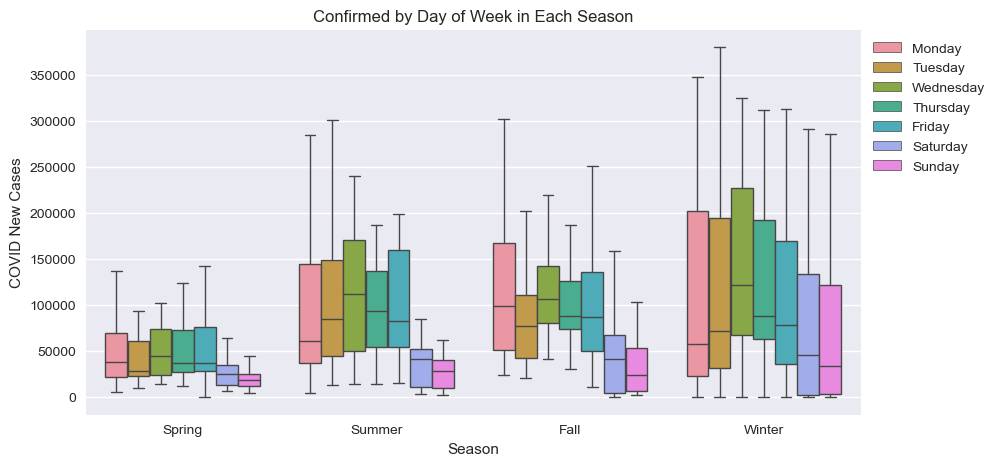

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='season',
            y='new_confirmed',
            hue='weekday',
            ax=ax,
            linewidth=1,
            showfliers=False)
ax.set_title('Confirmed by Day of Week in Each Season')
ax.set_xlabel('Season')
ax.set_ylabel('COVID New Cases')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()


### <a id='toc3_1_5_'></a>[ACF and PACF plots](#toc0_)

To determine the order of the AR and MA terms, we can plot the autocorrelation and partial autocorrelation charts.


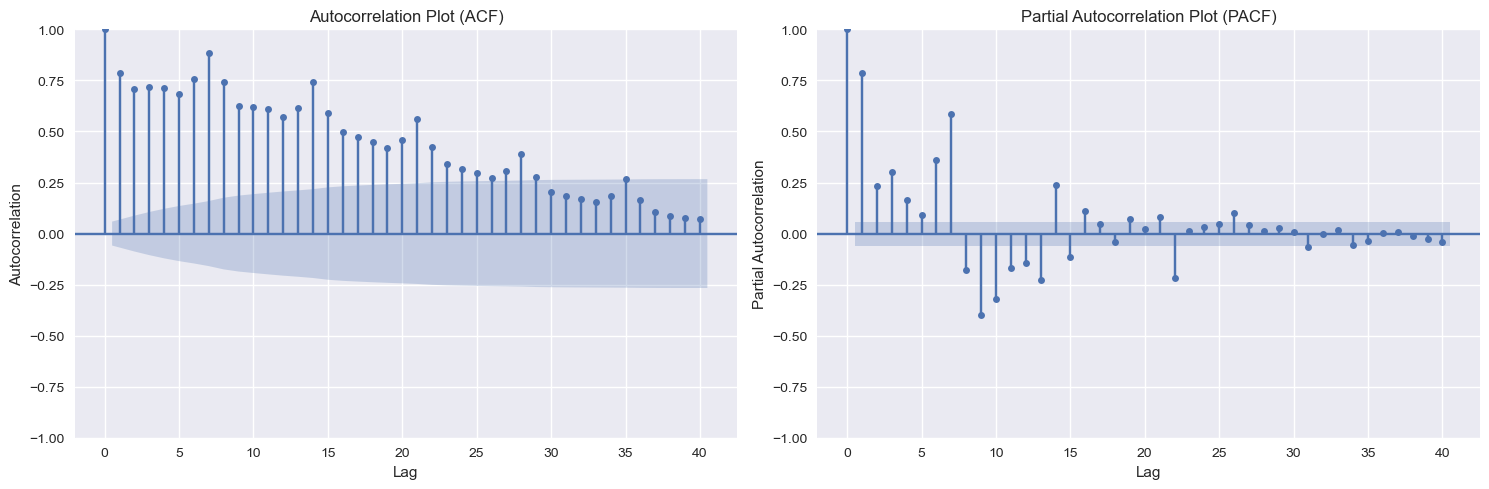

129454.11819880603

In [29]:
# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(train_df['new_confirmed'].dropna(), lags=40, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(train_df['new_confirmed'].dropna(), lags=40, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


train_df['new_confirmed'].std()

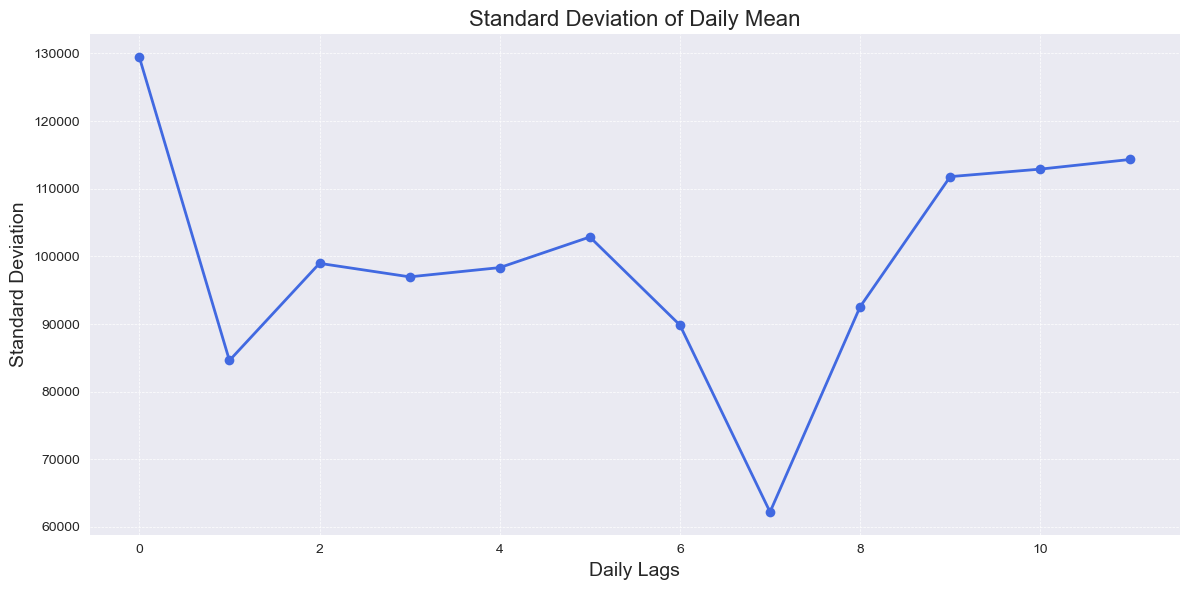

The Base Standard Deviation is : 129454.11819880603
The Standard Deviation of the Daily Mean is: 84612.25572999363
The Standard Deviation of the Daily Mean is: 98975.31644425403
The Standard Deviation of the Daily Mean is: 96977.74495075144
The Standard Deviation of the Daily Mean is: 98344.83706569567
The Standard Deviation of the Daily Mean is: 102870.2405894965
The Standard Deviation of the Daily Mean is: 89846.12892296682
The Standard Deviation of the Daily Mean is: 62216.87548014987
The Standard Deviation of the Daily Mean is: 92561.63539208613
The Standard Deviation of the Daily Mean is: 111795.39842489097
The Standard Deviation of the Daily Mean is: 112904.93488559195
The Standard Deviation of the Daily Mean is: 114336.77059583453


In [30]:
def plot_standard_deviation(data, freq, title):
    std_list = [data['new_confirmed'].std()]
    range_limit = 12 if freq == 'Daily' else 7
    for i in range(1, range_limit):
        diff_dev = data['new_confirmed'].diff(i).std()
        std_list.append(diff_dev)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(std_list, marker='o', linestyle='-', color='royalblue', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel(f'{freq} Lags', fontsize=14)
    plt.ylabel('Standard Deviation', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    

plot_standard_deviation(train_df, 'Daily', 'Standard Deviation of Daily Mean')

print('The Base Standard Deviation is :', train_df['new_confirmed'].std())

for i in range(1, 12):
    diff_dev = train_df['new_confirmed'].diff(i).std()
    
    print('The Standard Deviation of the Daily Mean is:', diff_dev)


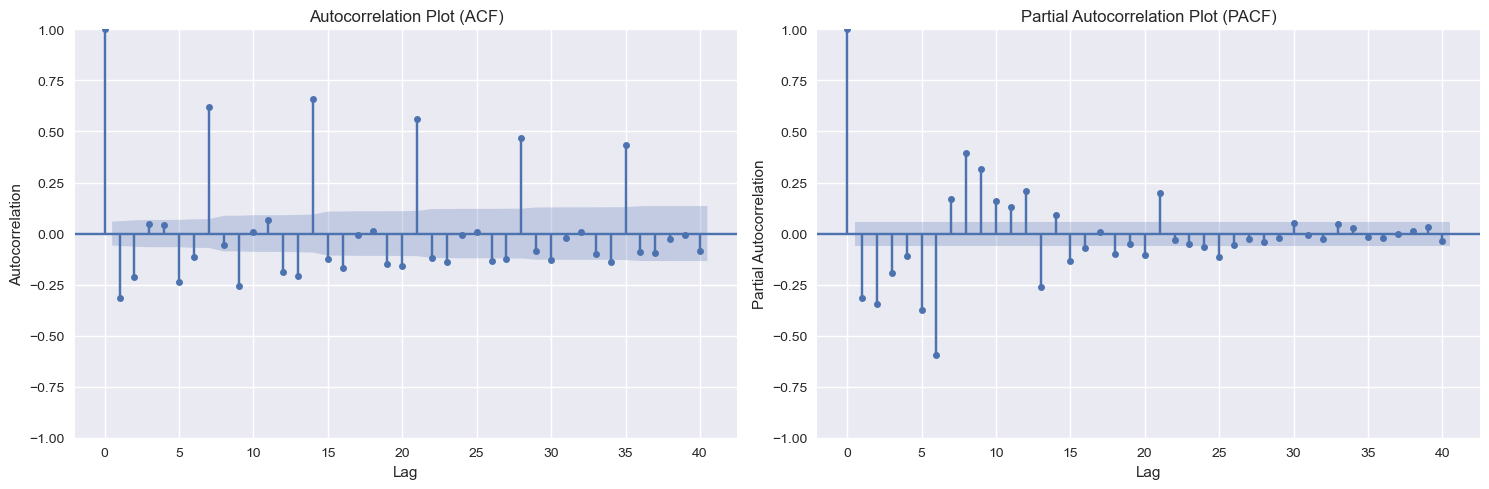

84612.25572999363

In [31]:
# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
adjusting_diff = 1

# Plot ACF
plot_acf(train_df['new_confirmed'].diff(adjusting_diff).dropna(), lags=40, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(train_df['new_confirmed'].diff(adjusting_diff).dropna(), lags=40, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


train_df['new_confirmed'].diff(adjusting_diff).std()

From the PACF it looks like our auto regressive model would only benefit by a 4-7 days. We will use this as our base p value.  
From our ACF graph it looks like our moving average model would only benefit by a maximum of 2 days. We will use this as our base q value.  

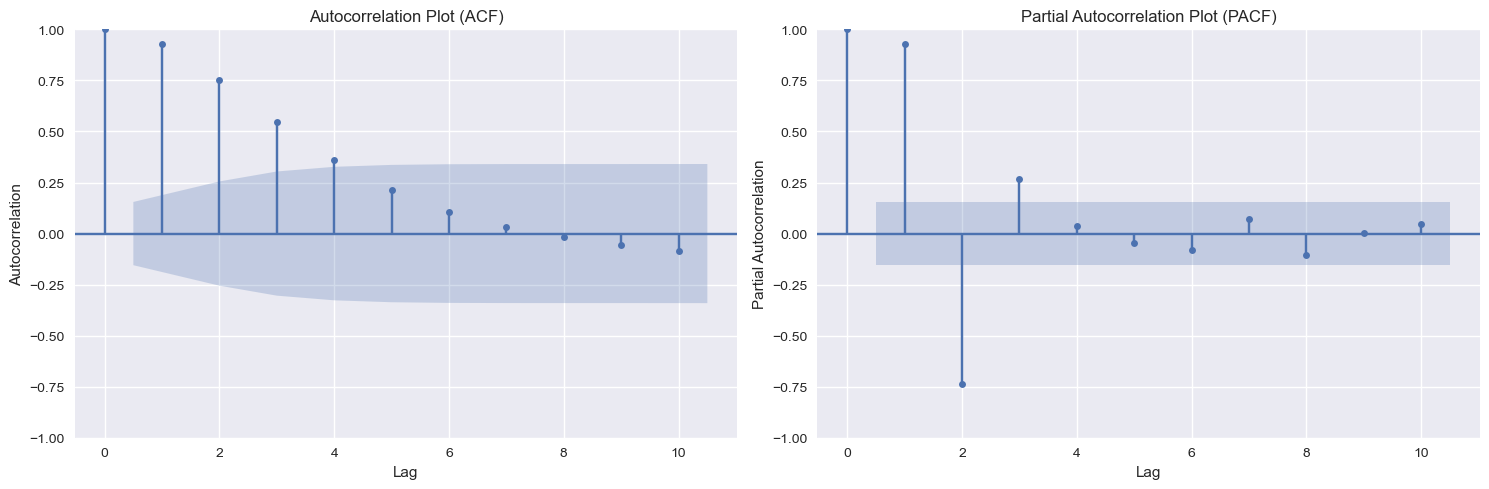

114093.20706126162

In [32]:
weekly_mean = train_df.resample('W').mean()


# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(weekly_mean['new_confirmed'].dropna(), lags=10, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(weekly_mean['new_confirmed'].dropna(), lags=10, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

weekly_mean['new_confirmed'].std()

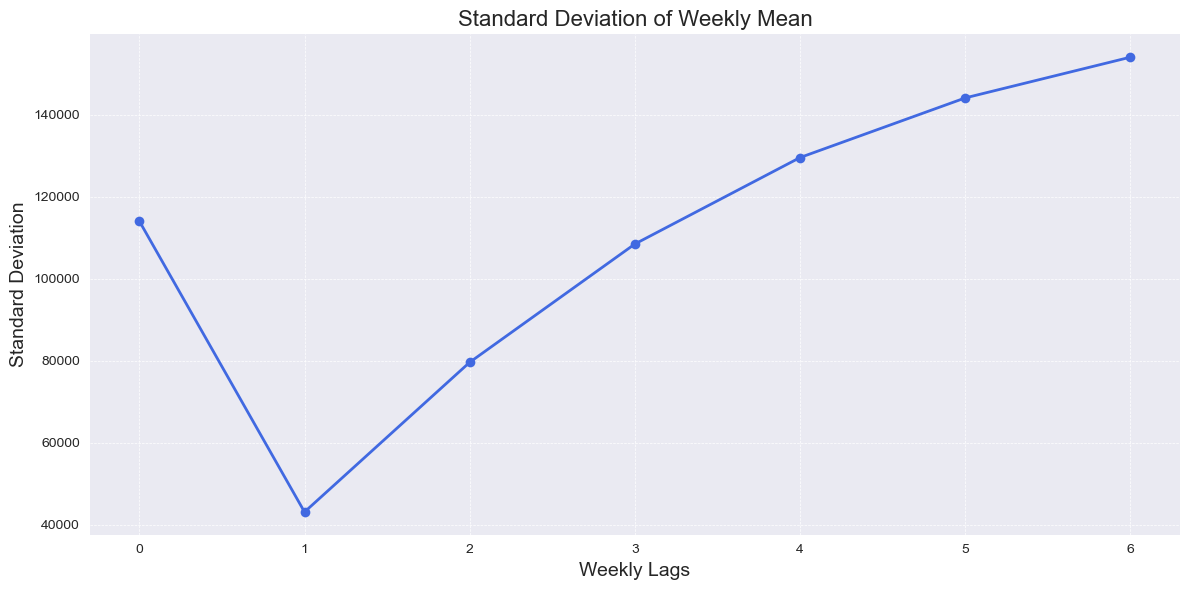

The Base Standard Deviation is : 114093.20706126162
The Standard Deviation of the Weekly Mean is: 43126.464797386936
The Standard Deviation of the Weekly Mean is: 79647.20760046186
The Standard Deviation of the Weekly Mean is: 108508.62119552917
The Standard Deviation of the Weekly Mean is: 129603.05891868124
The Standard Deviation of the Weekly Mean is: 144149.75885853491
The Standard Deviation of the Weekly Mean is: 154088.9335060596


In [33]:

# Plotting the two graphs with enhancements
plot_standard_deviation(weekly_mean, 'Weekly', 'Standard Deviation of Weekly Mean')

print('The Base Standard Deviation is :', weekly_mean['new_confirmed'].std())

for i in range(1, 7):
    diff_dev = weekly_mean['new_confirmed'].diff(i).std()
    
    print('The Standard Deviation of the Weekly Mean is:', diff_dev)


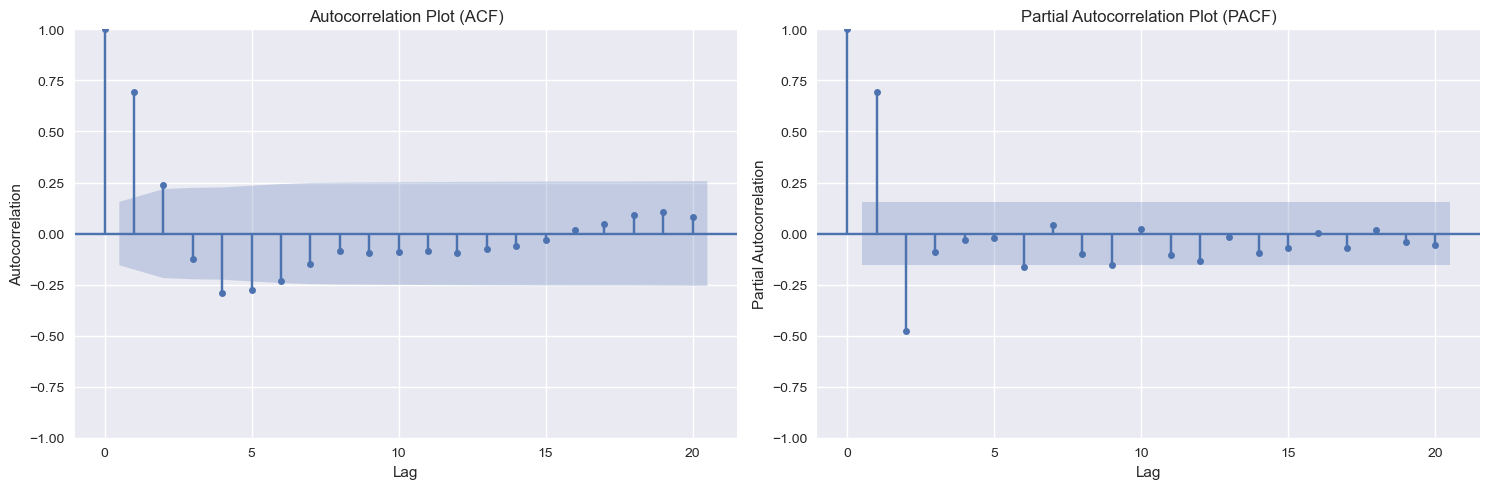

43126.464797386936

In [34]:
weekly_mean = train_df.resample('W').mean()
adjusting_diff = 1


# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(weekly_mean['new_confirmed'].diff(adjusting_diff).dropna(), lags=20, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(weekly_mean['new_confirmed'].diff(adjusting_diff).dropna(), lags=20, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

weekly_mean['new_confirmed'].diff(adjusting_diff).std()

### <a id='toc3_1_6_'></a>[Time Series Cross-Validation Setup](#toc0_)

In [35]:
number_of_folds = 42

fold_size = int(((len(train_df)-366)/number_of_folds))
adjustment=0

print("Fold Size =", fold_size)


# rolling_cv = RollingForecastCV(
#     h=fold_size,  # Forecast horizon (28 step ahead)
#     step=fold_size+adjustment,  # Step size for rolling window (28 step at a time)
#     initial=366)  # Skip the first 200 observations for warm-up


# # Plot the time series cross validation splits
# plot_cross_val(train_df,
#             'Time Series Rolling Forecast Cross-Validation',
#             fold_size,
#             rolling=True, 
#             adjustment=adjustment)

window_cv = pm.model_selection.SlidingWindowForecastCV(
    window_size=366, # Window size (366 observations)
    h=fold_size,  # Forecast horizon (17 step ahead)
    step=fold_size)  # Step size for rolling window (17 step at a time)

# Plot the time series cross validation splits
plot_cross_val(train_df,
            'Time Series Sliding Window Cross-Validation',
            fold_size,
            rolling=False, 
            adjustment=adjustment)

Fold Size = 17


# <a id='toc4_'></a>[Modeling](#toc0_)

## <a id='toc4_1_'></a>[ARIMA](#toc0_)

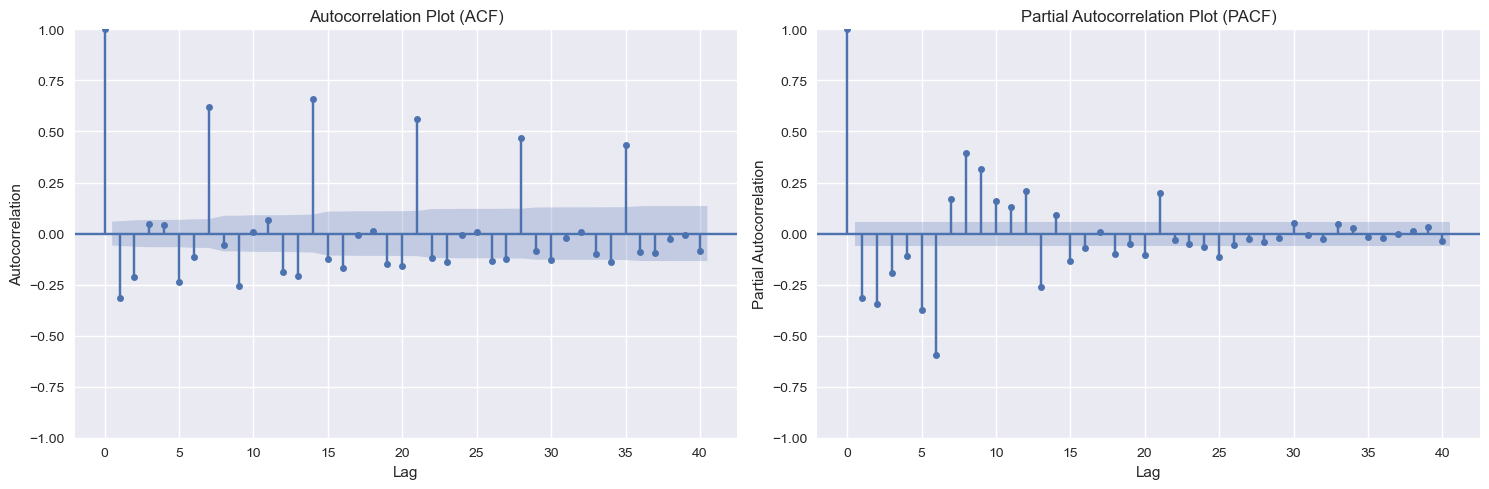

84612.25572999363

In [36]:
# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
adjusting_diff = 1

# Plot ACF
plot_acf(train_df['new_confirmed'].diff(adjusting_diff).dropna(), lags=40, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(train_df['new_confirmed'].diff(adjusting_diff).dropna(), lags=40, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


train_df['new_confirmed'].diff(adjusting_diff).std()

### <a id='toc4_1_1_'></a>[Base Arima Model](#toc0_)

In [37]:
# Flag to determine if the model should be trained or loaded from disk

# Check if the training flag is set to True
if training:
    
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    # and then fits an ARIMA model to the transformed data.
    estimators = [
        ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
        ("model", pm.arima.ARIMA(order= (6,1,2), 
                    suppress_warnings=True,
                    random_state=42)) # ARIMA model                   
                        ]
    pipeline = Pipeline(estimators)

else:
    # If not training, then load the pre-trained model from disk
    model_1 = joblib.load('models/ARIMA(6,1,2)(0,0,0)[0] intercept.pkl')
    print("model_1 loaded successfully")



0it [00:00, ?it/s]

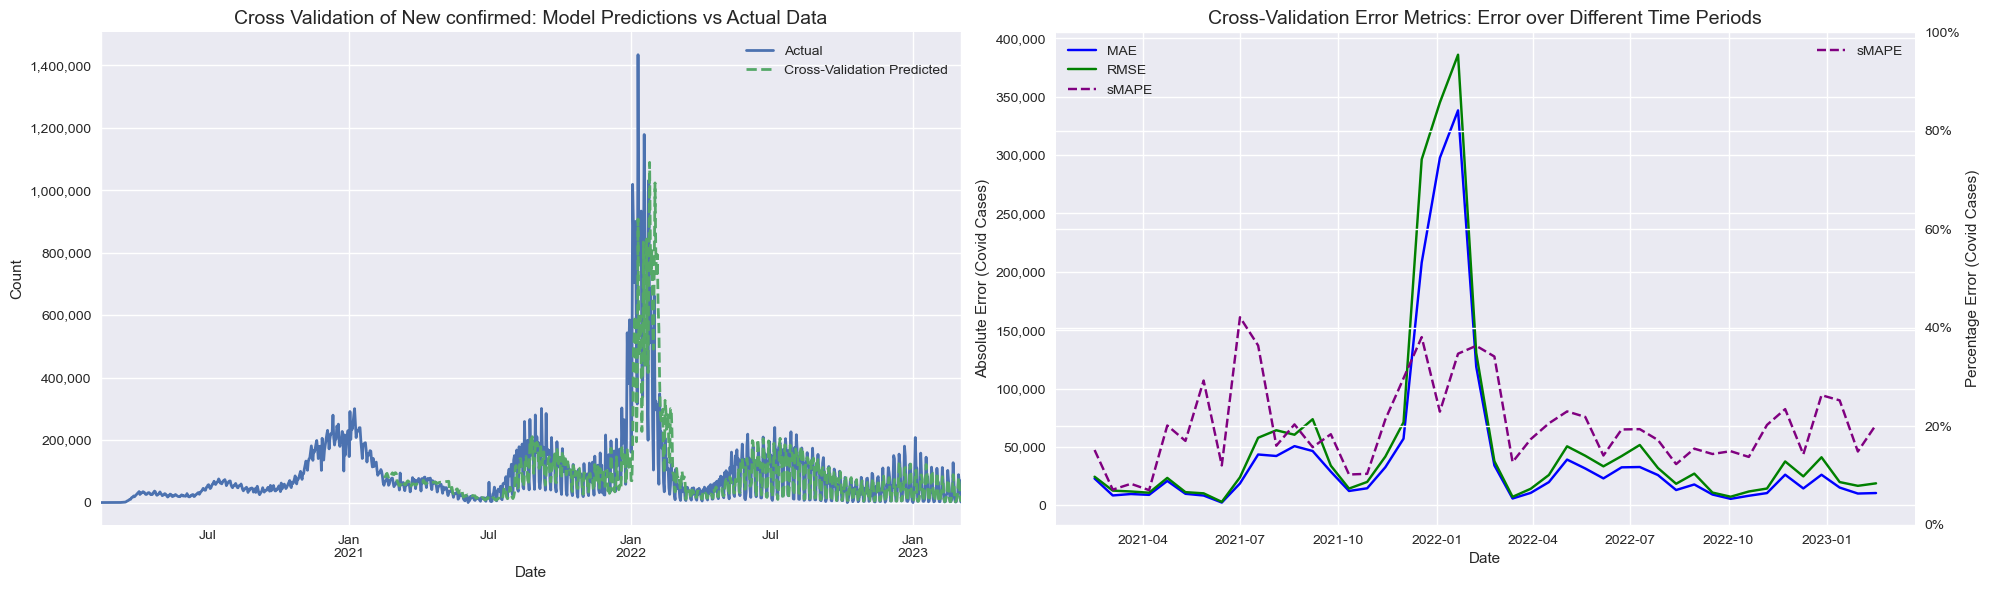

In [38]:

if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_1 = train_model(y_train, pipeline, window_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, 'new_confirmed')


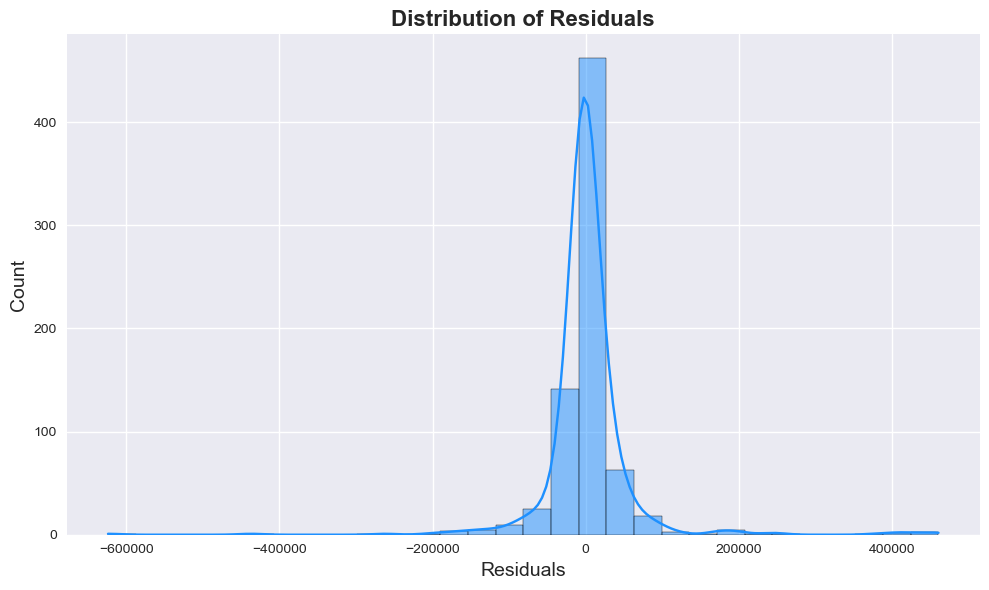

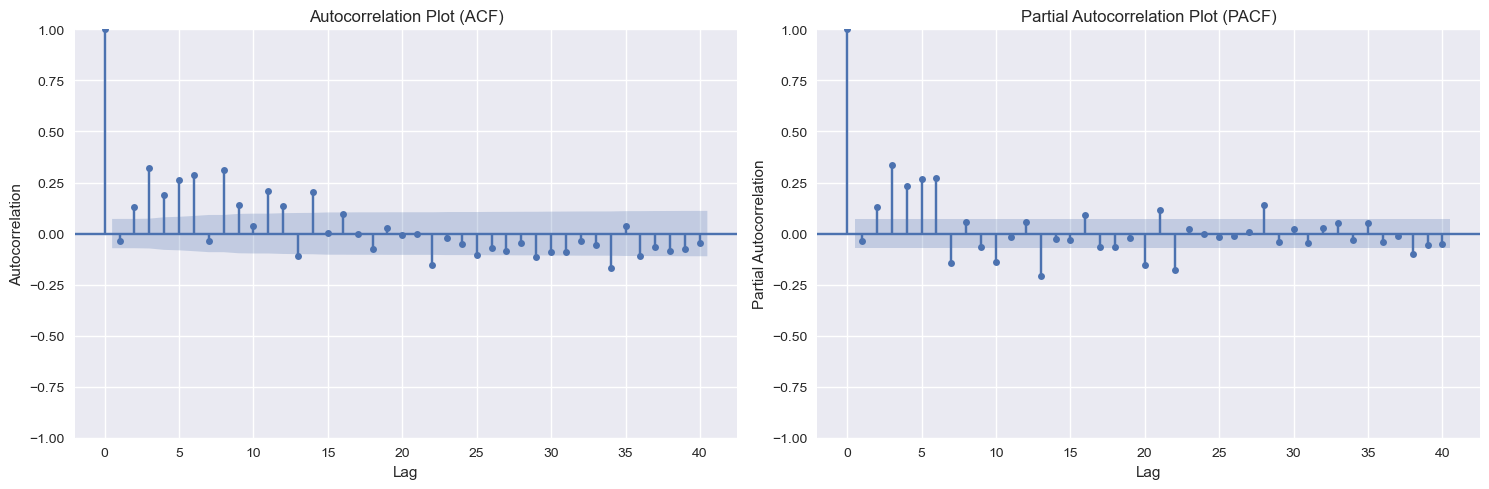

In [39]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_1)


In [40]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_1)


In [41]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = str(model_1.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

In [42]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_1, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_1.summary()

Model pickled to models/ARIMA(6,1,2)(0,0,0)[0] intercept.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1114
Model:               SARIMAX(6, 1, 2)   Log Likelihood               -3722.375
Date:                Fri, 11 Aug 2023   AIC                           7464.750
Time:                        16:28:06   BIC                           7514.898
Sample:                             0   HQIC                          7483.710
                               - 1114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2782      0.325      0.856      0.392      -0.359       0.915
ar.L1         -0.8418      0.021    -39.999      0.000      -0.883      -0.801
ar.L2         -0.9330      0.014    -65.185      0.000      -0.961      -0.905
ar.L3         -0.8681      0.017    -49.704      0.000      -0.902      -0.834
ar.L4         -0.8580      0.017    -50.819      0.000      -0.891      -0.825
ar.L5         -0.8928      0.014    -63.386      0.000      -0.920      -0.865
ar.L6         -0.7685      0.016    -47.019      0.000      -0.801      -0.736
ma.L1          0.1271      0.027      4.739      0.000       0.075       0.180
ma.L2          0.3273      0.030     10.907      0.000       0.268       0.386
sigma2        46.7182      1.049     44.552      0.000      44.663      48.773
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):              2242.88
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               5.24   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='toc4_1_2_'></a>[Tuned Arima Model](#toc0_)

In [43]:


# Check if the training flag is set to True
if training:
    if searching:
        # If searching is required:
        estimators = [
        ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
        ("model", pm.auto_arima(y_train))]  # Data for ARIMA model selection
        
        # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
        # and then automatically determines the best ARIMA order within the given range using auto_arima.
        estimators = [
            ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
            ("model", pm.auto_arima( y_train,  # Data for ARIMA model selection
                            # d=1,  # Differencing order
                            start_p=0,  # Initial AR order for search
                            start_q=0,   # Initial MA order for search
                            max_p=9,    # Maximum AR order for search
                            max_q=3,    # Maximum MA order for search
                            seasonal=False,  # No seasonal component
                            trace=True,
                            stepwise=False,
                            n_jobs=-1,
                            random_state=42))]  # Print the search progress

        pipeline = Pipeline(estimators)  # Construct the pipeline
    
    else:
        estimators = [
        ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
        ("model", pm.arima.ARIMA(order= [3, 1, 2], 
                        seasonal=False,
                        suppress_warnings=True,
                        random_state=42))                   
                        ]

        pipeline = Pipeline(estimators) 
    
else:
    # If not training, then load the pre-trained model from disk
    model_2 = joblib.load('models/ARIMA(3,1,2)(0,0,0)[0].pkl')
    print("model_2 loaded successfully")
    


Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 5.463 seconds


0it [00:00, ?it/s]

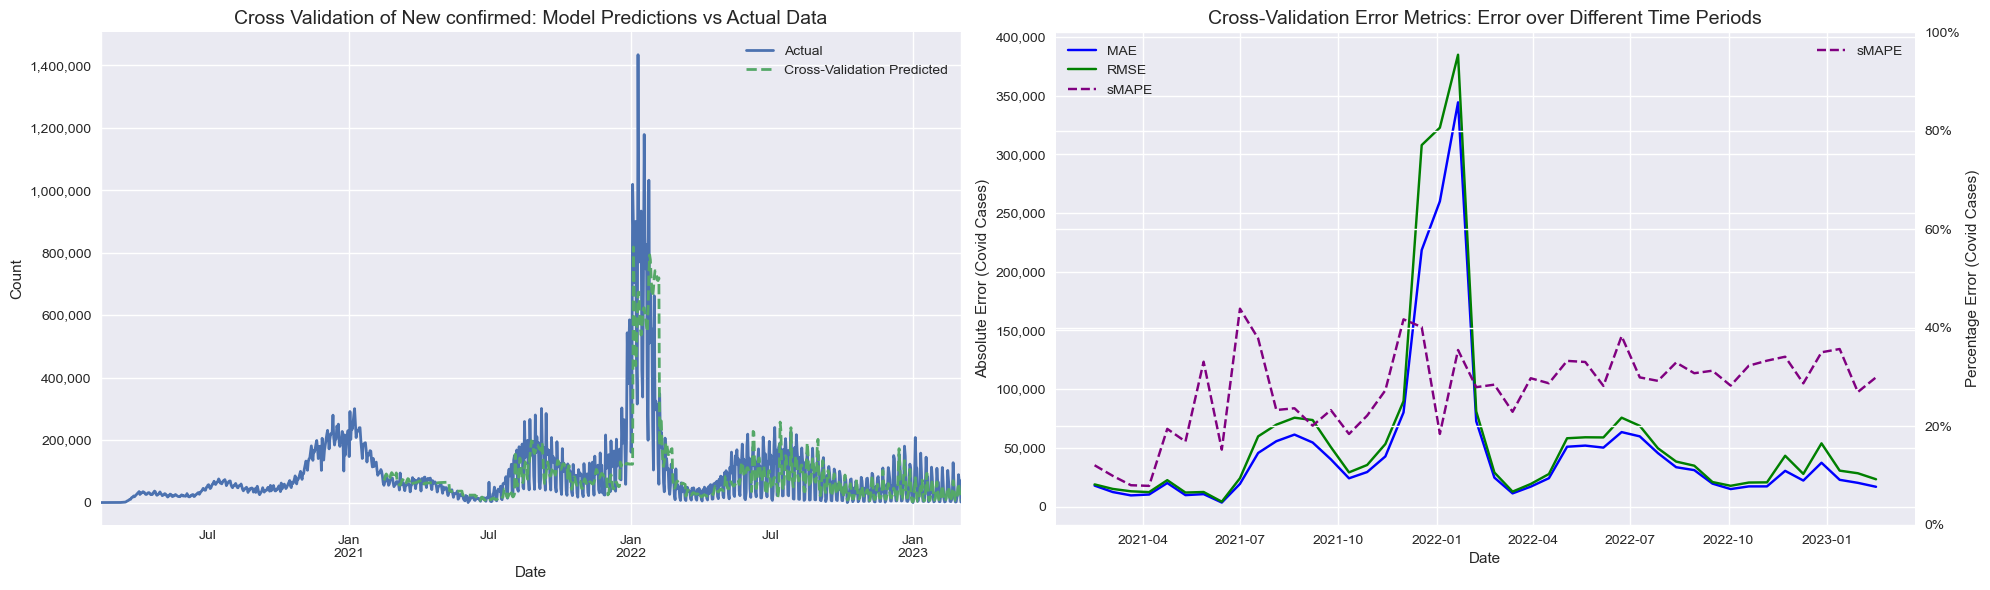

In [44]:

if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_2 = train_model(y_train, pipeline, window_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)


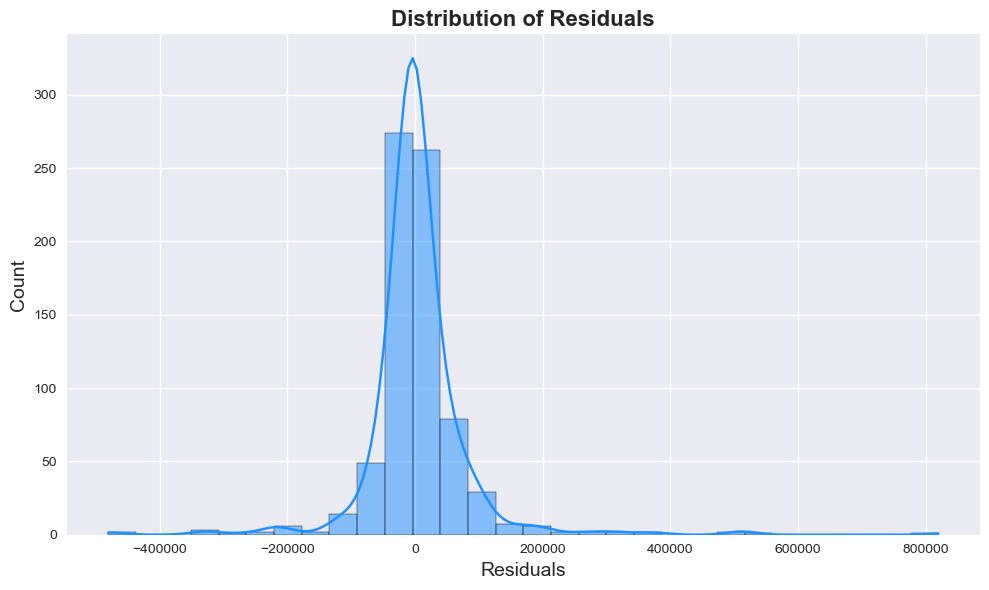

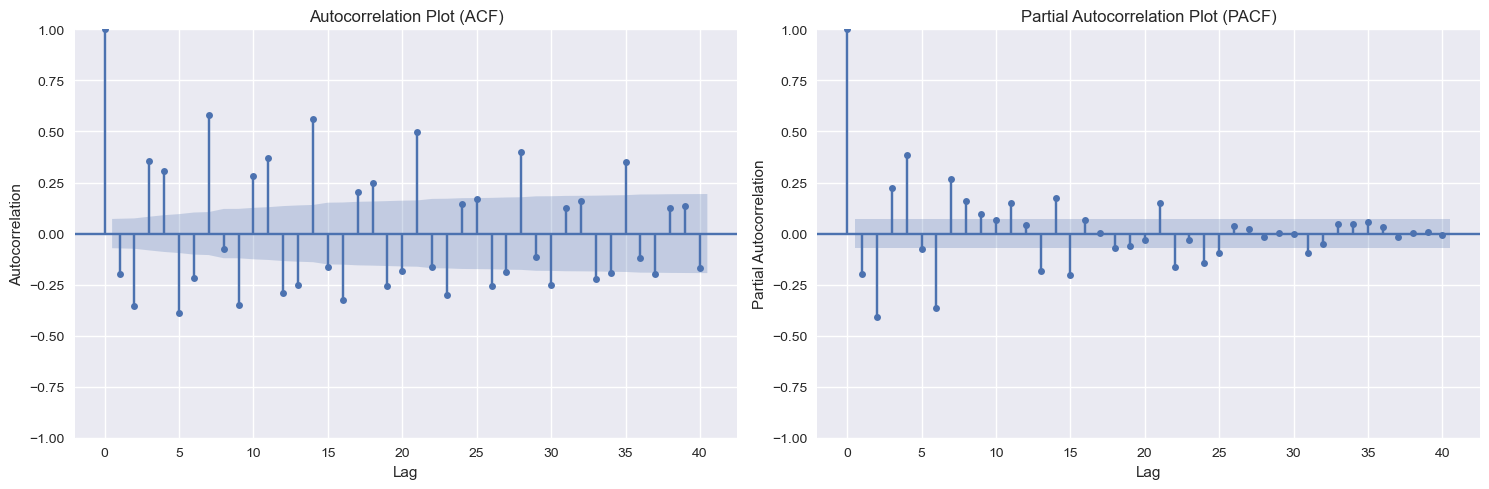

In [45]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_2)


In [46]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_2)


In [47]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = str(model_2.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

In [48]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_2, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_2.summary()


Model pickled to models/ARIMA(3,1,2)(0,0,0)[0] intercept.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1114
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -4083.531
Date:                Fri, 11 Aug 2023   AIC                           8181.062
Time:                        16:28:46   BIC                           8216.165
Sample:                             0   HQIC                          8194.334
                               - 1114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0515      0.118      0.436      0.663      -0.180       0.283
ar.L1          0.7763      0.026     30.111      0.000       0.726       0.827
ar.L2         -0.4184      0.030    -14.004      0.000      -0.477      -0.360
ar.L3         -0.4011      0.027    -14.643      0.000      -0.455      -0.347
ma.L1         -1.4664      0.016    -88.906      0.000      -1.499      -1.434
ma.L2          0.8473      0.015     54.758      0.000       0.817       0.878
sigma2        89.6829      2.920     30.713      0.000      83.960      95.406
===================================================================================
Ljung-Box (L1) (Q):                  22.78   Jarque-Bera (JB):                99.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.63   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## <a id='toc4_2_'></a>[SARIMA](#toc0_)

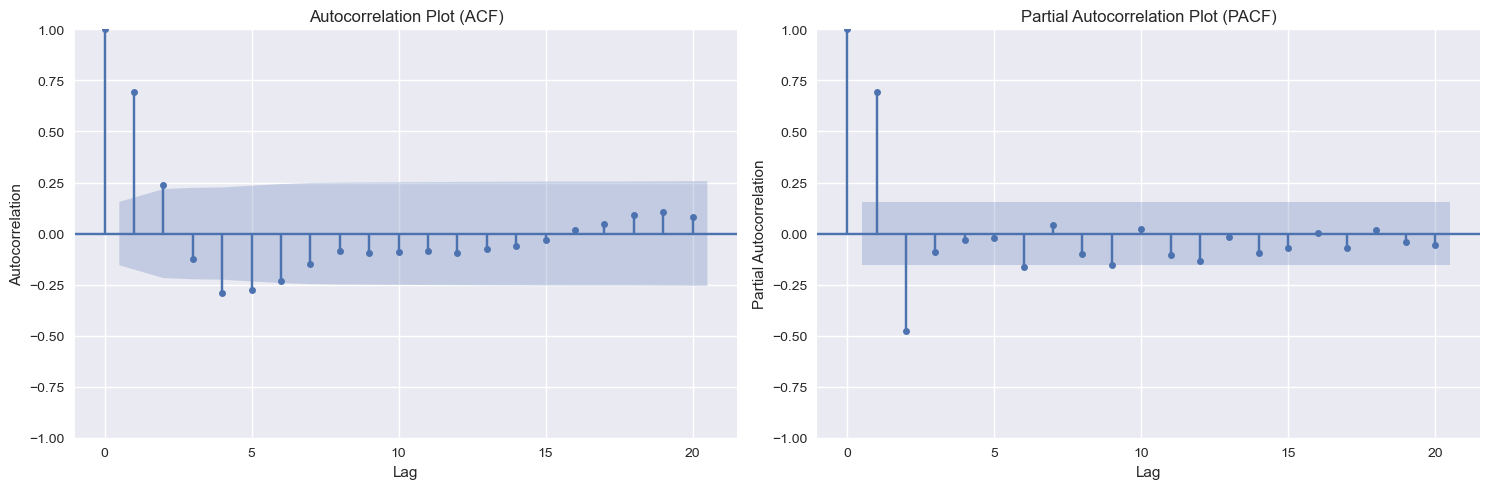

43126.464797386936

In [49]:
other_interval = train_df.resample('W').mean()
adjusting_diff = 1


# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(other_interval['new_confirmed'].diff(adjusting_diff).dropna(), lags=20, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(other_interval['new_confirmed'].diff(adjusting_diff).dropna(), lags=20, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

other_interval['new_confirmed'].diff(adjusting_diff).std()

In [50]:
check_stationarity(other_interval.new_confirmed)

Test Statistic                -3.986446
p-value                        0.001483
Number of Observations Used    2.000000
dtype: float64

### <a id='toc4_2_1_'></a>[Base SARIMA Model](#toc0_)

In [51]:
# Flag to determine if the model should be trained or loaded from disk

# Check if the training flag is set to True
if training:
    
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= [3, 1, 2], 
                    seasonal_order =[2, 1, 2, 7],
                    suppress_warnings=True,
                    random_state=42))                   
                    ]

    pipeline = Pipeline(estimators) 

else:
    # If not training, then load the pre-trained model from disk
    model_3 = joblib.load('models/Seasonal ARIMA(3,1,2)(2,1,1)[7] intercept.pkl')
    print("model_3 loaded successfully")



0it [00:00, ?it/s]

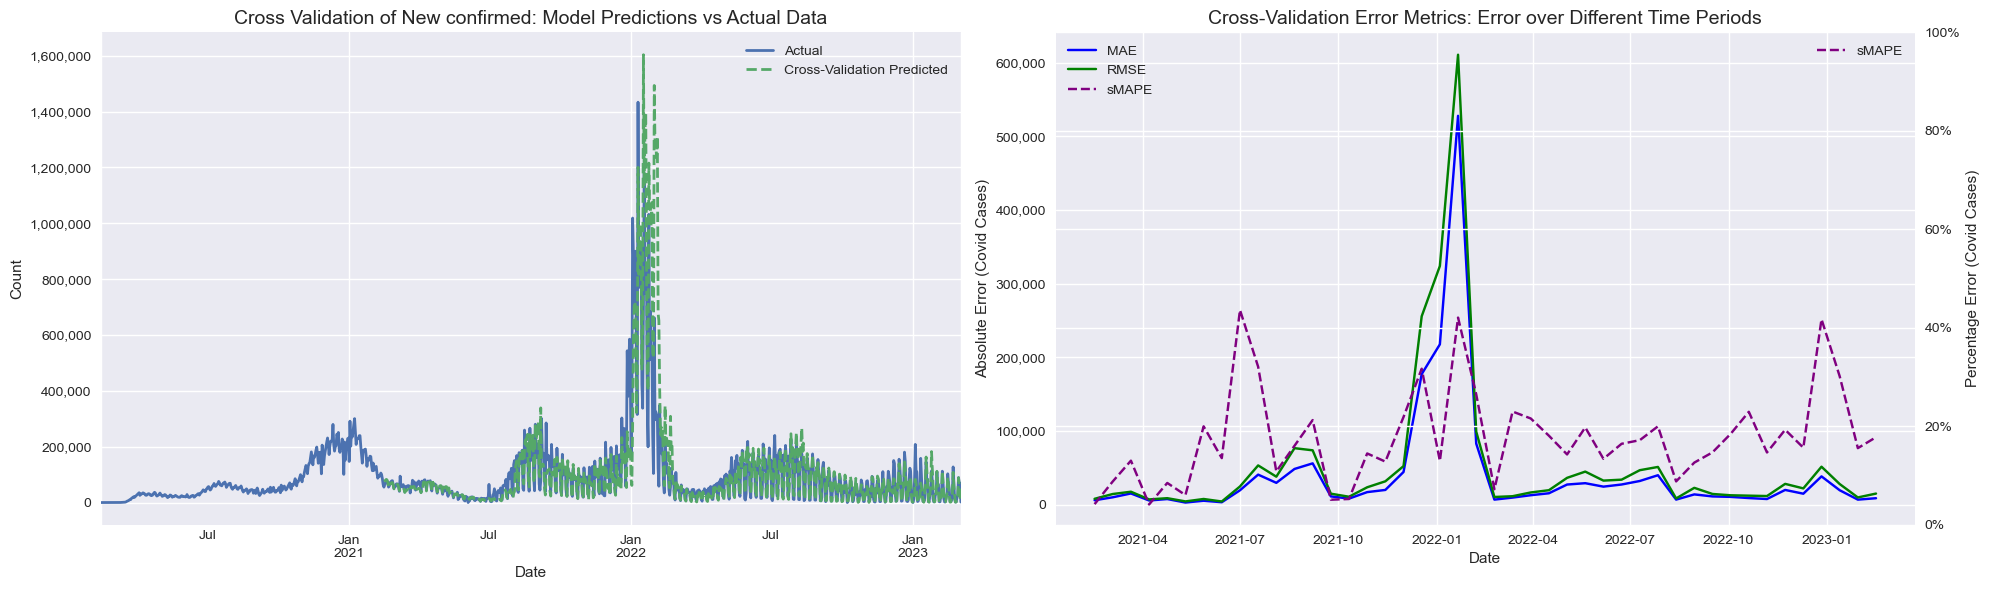

In [52]:

if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_3 = train_model(y_train, pipeline, window_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)


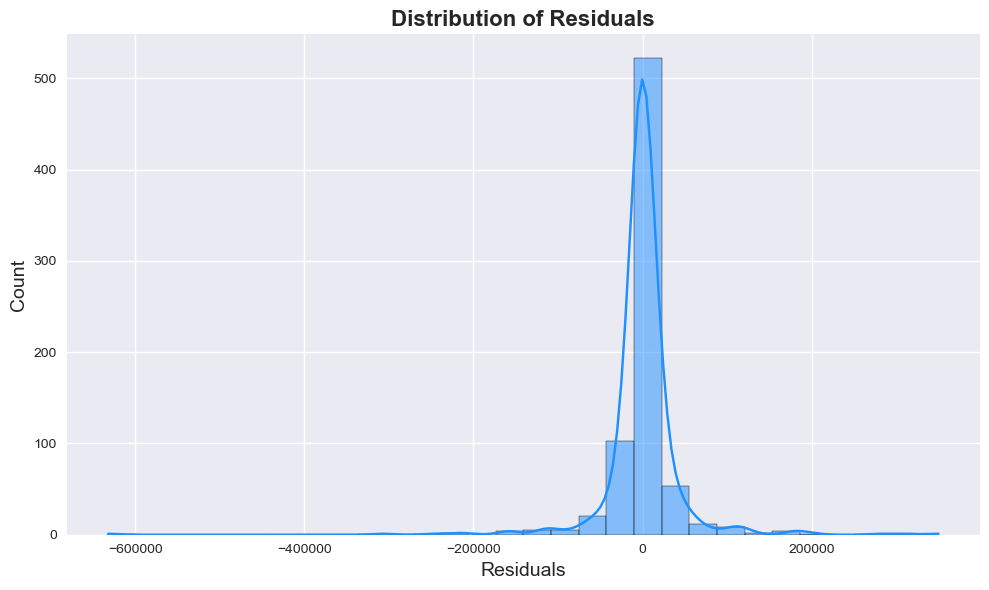

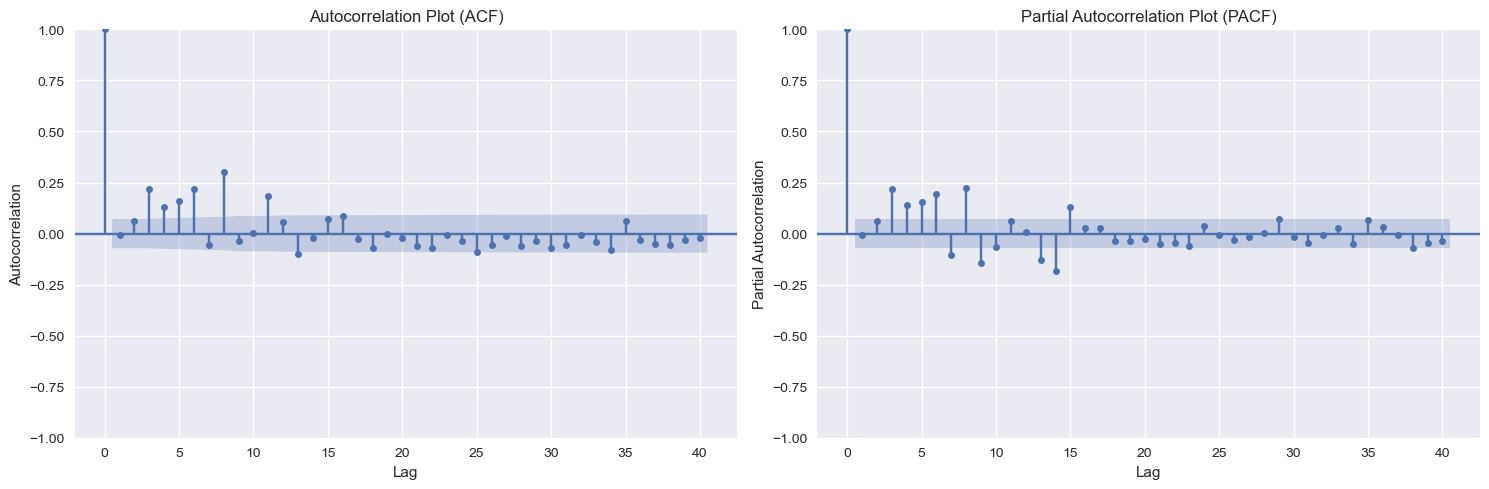

In [53]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_3)


In [54]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_3)


In [55]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Seasonal ' + str(model_3.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()

in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

In [56]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"

    # Attempt to save the model to disk using pickling
    joblib.dump(model_3, pickle_tgt, compress=3)
    print("Model pickled to %s" % pickle_tgt)


# Display the summary of the trained model
model_3.summary()

Model pickled to models/Seasonal ARIMA(3,1,2)(2,1,2)[7] intercept.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1114
Model:             SARIMAX(3, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -3490.555
Date:                           Fri, 11 Aug 2023   AIC                           7003.111
Time:                                   16:33:05   BIC                           7058.204
Sample:                                        0   HQIC                          7023.947
                                          - 1114                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0034      0.012     -0.288      0.773      -0.027       0.020
ar.L1         -0.8696      0.148     -5.889      0.000      -1.159      -0.580
ar.L2         -0.1663      0.064     -2.585      0.010      -0.292      -0.040
ar.L3         -0.1026      0.038     -2.677      0.007      -0.178      -0.027
ma.L1          0.1454      0.146      0.996      0.319      -0.141       0.431
ma.L2         -0.4415      0.119     -3.718      0.000      -0.674      -0.209
ar.S.L7        0.4696      0.159      2.946      0.003       0.157       0.782
ar.S.L14       0.1418      0.035      4.049      0.000       0.073       0.211
ma.S.L7       -1.1881      0.162     -7.341      0.000      -1.505      -0.871
ma.S.L14       0.2757      0.126      2.191      0.028       0.029       0.522
sigma2        32.1352      0.660     48.694      0.000      30.842      33.429
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4679.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.83   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='toc4_2_2_'></a>[Tuned SARIMA Model](#toc0_)

In [57]:
# Flag to determine if the model should be trained or loaded from disk


# # Check if the training flag is set to True
if training:
    if searching:
        # # If training is required:
        
        # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
        # and then automatically determines the best ARIMA order within the given range using auto_arima.
        estimators = [
            ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
            ("model", pm.auto_arima(y_train,
                            # d=1,
                            start_p=2, 
                            max_p=6, 
                            max_q=3, 
                            max_P=4, 
                            max_Q=3,
                            # D=1,
                            m=7,
                            seasonal=True, 
                            trace=True,
                            random_state=42, 
                            stepwise=False, 
                            suppress_warnings=True,
                            n_jobs=-1))]

        pipeline = Pipeline(estimators)
    else:
        # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
        estimators = [
        ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
        ("model", pm.arima.ARIMA(order= [2, 1, 2], 
                        seasonal_order =[1, 0, 0, 7],
                        suppress_warnings=True,
                        random_state=42))                   
                        ]

        pipeline = Pipeline(estimators) 


else:
    try:
        # If not training, then load the pre-trained model from disk
        model_4 = joblib.load('models/Seasonal ARIMA(2,1,2)(1,0,0)[7] intercept.pkl')
        print("model_4 loaded successfully")
    except:
        print("Error loading model_4")



Best model:  ARIMA(2,1,2)(1,0,0)[7] intercept
Total fit time: 16.537 seconds


0it [00:00, ?it/s]

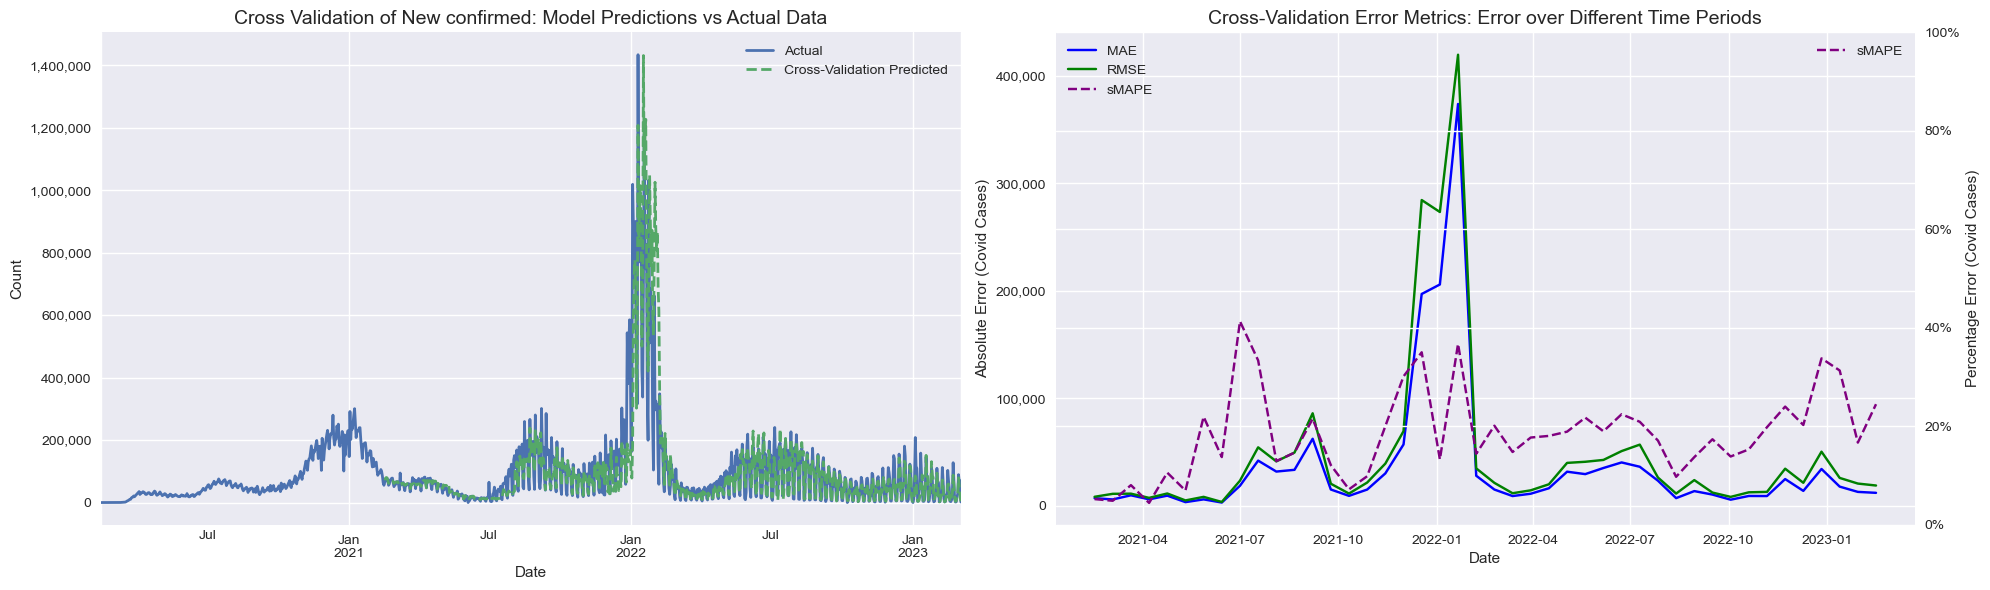

In [58]:

if training:
    # If in training mode:

    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_4 = train_model(y_train, pipeline, window_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)


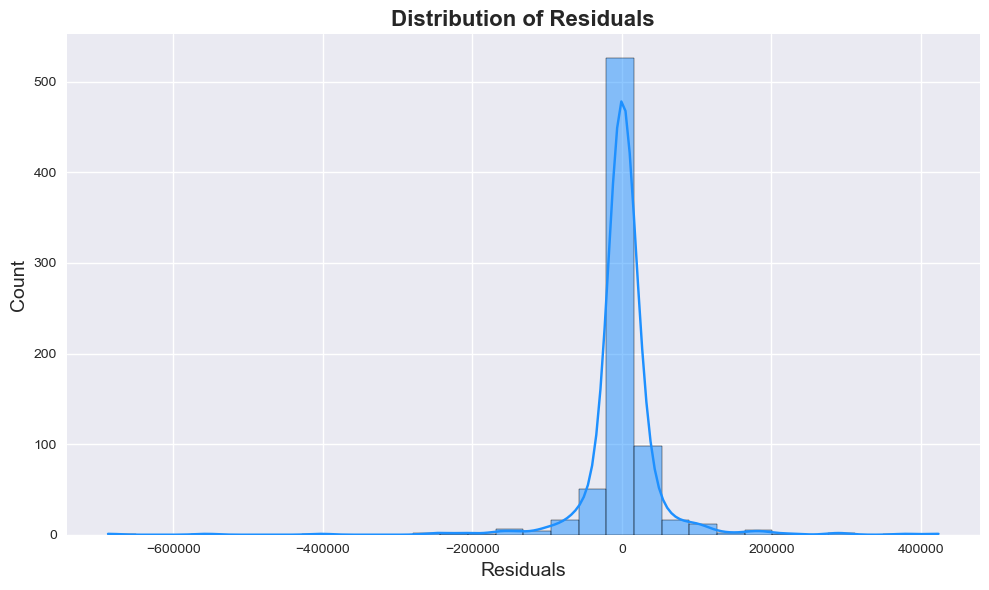

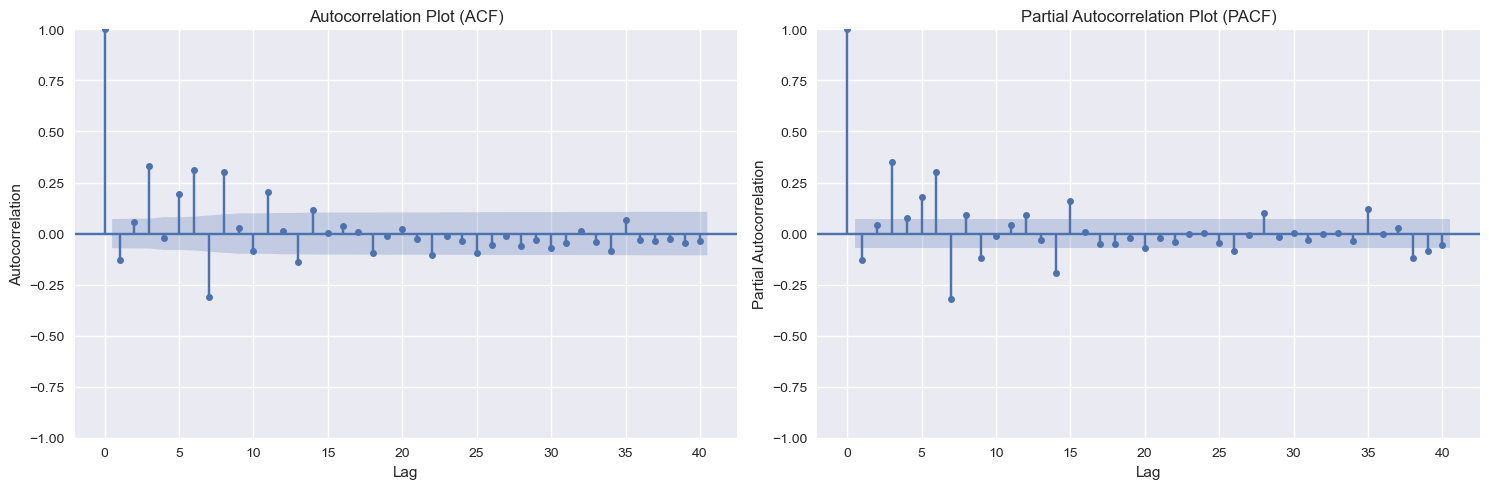

In [59]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_4)


In [60]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_4)


In [61]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Seasonal ' + str(model_4.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

In [62]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_4, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")

# Display the summary of the trained model
model_4.summary()

Model pickled to models/Seasonal ARIMA(2,1,2)(1,0,0)[7] intercept.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1114
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 7)   Log Likelihood               -3693.928
Date:                            Fri, 11 Aug 2023   AIC                           7401.856
Time:                                    16:33:44   BIC                           7436.960
Sample:                                         0   HQIC                          7415.129
                                           - 1114                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0154      0.056      0.275      0.783      -0.094       0.125
ar.L1         -0.7610      0.054    -14.085      0.000      -0.867      -0.655
ar.L2          0.1535      0.031      5.023      0.000       0.094       0.213
ma.L1         -0.0047      0.051     -0.092      0.926      -0.104       0.095
ma.L2         -0.7309      0.038    -18.983      0.000      -0.806      -0.655
ar.S.L7        0.8564      0.011     77.707      0.000       0.835       0.878
sigma2        44.3176      0.929     47.710      0.000      42.497      46.138
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3112.43
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               7.51   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## <a id='toc4_3_'></a>[Sarimax](#toc0_)

### <a id='toc4_3_1_'></a>[Selection of Exogenous variables:](#toc0_)

This is crucial for SARIMAX to gain any effectiveness over the SARIMA model. Here I wanted to choose variables I believed had a causal relationship with the response variable: the most obvious ones were going to be hospitalizations, new deaths, stringency, and reproduction rate. I then used stepwise regression with LGBMRegressor to select the most significant variables. 

**Recursive Feature Elimination (RFE):** 

RFE is a feature selection technique that aims to select features by recursively considering smaller and smaller sets of features. The procedure is as follows:

1. The estimator is trained on the initial set of features and the importance of each feature is obtained.
2. The least important features are pruned from the current set of features.
3. The procedure is recursively repeated on the pruned set until the desired number of features to select is reached.

By doing this, RFE narrows down the most significant variables/features for the model.

In this case, the estimator is LGBMRegressor, which is a gradient boosting framework that uses tree-based learning algorithms. It's important to note that LGBMRegressor is robust against multicollinearity. I'm going to get the top 10 most important features in the tree-based model with the least important feature being eliminate at each step. I also removed any possible colinear variables and date variables from the exogenous variables because this information is already present in the model. 

In conclusion, this process helps in automating the feature selection process, ensuring that you're working with only the most influential features when building your final model.

**Other Requirements of Exogenous Variables for SARIMAX: Low Multicollinearity and Stationarity**

Finally, I then have to make sure the selected exogenous variables are avoid multicollinearity. I will be using the Variance Inflation Factor (VIF) to check for multicollinearity, then eliminating the variables that have high multicolinearity from the RFE variable search with LGBMRegression. I also have to make sure the exogenous variables are stationary. I will be using the Augmented Dickey-Fuller (ADF) test to check for stationarity. 



In [63]:
variable_dicts = {'All': all_variables, 'Not_Colin': Not_Colin,
                'Prior': prior_assumption, 'Big': somewhat_important,
                'Excessive':frequently_removed_variables, 'Not_Epid': list(set(all_variables) - set(epidemiological_variables)),
                'SIRD': sird_variables, "Government": restriction_variables, 'Epid': epidemiological_variables,
                'Dates': date_variables, 'Not_Epi_Col': list((set(all_variables) - set(epidemiological_variables)) - set(colinear_variables))}


Stationarity Checks

In [64]:
# List to collect the 'Test Statistic' values for each feature
test_statistics = {}

for i in Not_Colin:
   # Difference the 'confirmed' series by the current level and drop NA values
    series = X_train[i].dropna()
    
    # Get the test statistic from the stationarity check and append to the list
    test_statistics[i] = check_stationarity(series).loc[['Test Statistic', 'p-value']]

stationarity_series = pd.DataFrame(test_statistics).T
stationarity_series.style.background_gradient(cmap='coolwarm', subset='p-value', vmin=0.00, vmax=0.05)

In [65]:
stationarity_verified = stationarity_series[stationarity_series['p-value'] <= 0.05].index

stationary_X_train = X_train[stationarity_verified]

Causality Check

In [66]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag= 6
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            try:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
            except:
                print('Couldn\'t calculate Granger Causality for {} and {}.'.format(r, c))
                continue
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

causality_matrix = grangers_causation_matrix(train_df[list(stationarity_verified) + ['new_confirmed']], 
                        variables = train_df[list(stationarity_verified) + ['new_confirmed']].columns)

causality_matrix.loc['new_confirmed_y',:].sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm')

Couldn't calculate Granger Causality for dayofweek and kap_mortality_rate.
Couldn't calculate Granger Causality for dayofweek and sig_recovery_rate.
Couldn't calculate Granger Causality for dayofweek and t/k_mortality_period.
Couldn't calculate Granger Causality for dayofweek and month.
Couldn't calculate Granger Causality for dayofweek and current_intensive_care_patients.
Couldn't calculate Granger Causality for dayofweek and rho_transmission_rate.
Couldn't calculate Granger Causality for dayofweek and t/r_infection_period.
Couldn't calculate Granger Causality for dayofweek and internal_movement_restrictions.
Couldn't calculate Granger Causality for dayofweek and t/s_recovery_period.
Couldn't calculate Granger Causality for dayofweek and excess_mortality.
Couldn't calculate Granger Causality for dayofweek and school_closing.
Couldn't calculate Granger Causality for dayofweek and new_bi_weekly_vaccinations.
Couldn't calculate Granger Causality for dayofweek and excess_mortality_cumulat

Here I removed any variable that lacked a feature of significance 0.05 or higher. However, I kept stringency_index and derived_reproduction_rate as I thought these might still have information to give to the model. 

In [67]:
causality_verified = list(set(stationarity_verified) - set(['school_closing', 'dayofmonth', 'internal_movement_restrictions', 
                                                    'workplace_closing', 't/s_recovery_period', 'information_campaigns', 't/k_mortality_period']))

causality_X_train = X_train[causality_verified]

Correlation Check

In [68]:
display(causality_X_train.corrwith(y_train, method='spearman').rename('Correlation Strength').sort_values(ascending=False)
        .to_frame().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))

print("Starting Correlation Strength:", np.abs(causality_X_train.corrwith(y_train, method='spearman')).sum())

Starting Correlation Strength: 5.378930066272563


This allowed me to know which variables might contribute more linear information to my model.

Multi-Collinearity Check

In [69]:
def vif_checker(df):
    df = add_constant(df)
    #  VIF values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns

    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    display(vif_data.sort_values(by='VIF', ascending=False).style.background_gradient(cmap='coolwarm', vmax=10))
    df.drop(columns=['const'], inplace=True)
    
    return vif_data

vif_checker(causality_X_train)
reduced_multi_col = causality_X_train.drop(['dayofyear', 'current_intensive_care_patients', 'excess_mortality', 'derived_reproduction_rate'], axis=1)


vif_checker(reduced_multi_col)

print('Correlation Strength Remaining: ', np.abs(reduced_multi_col.corrwith(y_train, method='spearman')).sum())

Correlation Strength Remaining:  4.143707302594313


Importance Check

<Axes: >

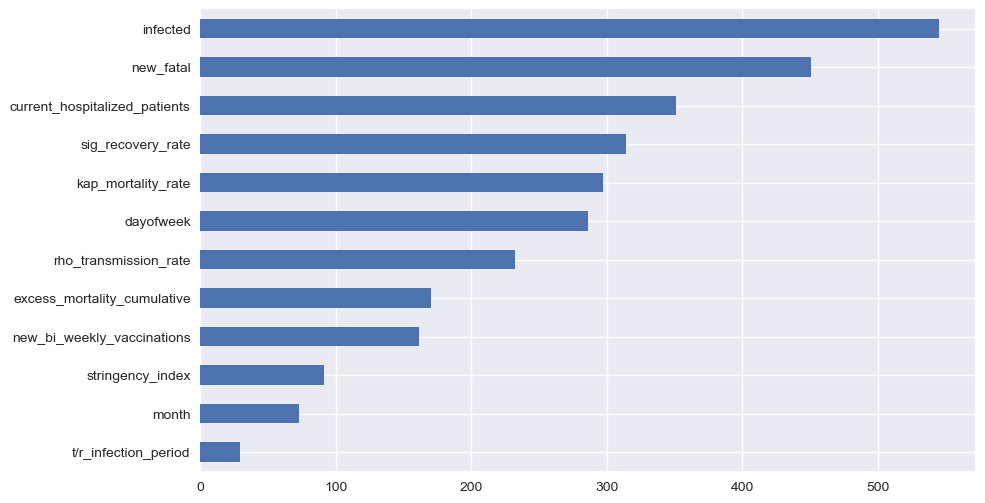

In [70]:
# #Selecting the Best important features according to RandomForestRegressor or LGBMRegressor which is resilient to multi-colinearity
rfe_selector = RFE(estimator=LGBMRegressor(random_state=42), n_features_to_select = 15, step = 1)
rfe_selector.fit(reduced_multi_col, y_train)
most_important = list(reduced_multi_col.columns[rfe_selector.get_support()])
pd.Series(index=most_important, data=rfe_selector.estimator_.feature_importances_).sort_values().plot(kind='barh', figsize=(10, 6))


This assess for non-linear importance. Not as important with this model, but performed for completeness.

Visualize Relationships between remaining variables:

['kap_mortality_rate',
 'month',
 'sig_recovery_rate',
 'excess_mortality_cumulative',
 'rho_transmission_rate',
 't/r_infection_period',
 'current_hospitalized_patients',
 'dayofweek',
 'new_fatal',
 'new_bi_weekly_vaccinations',
 'infected',
 'stringency_index']

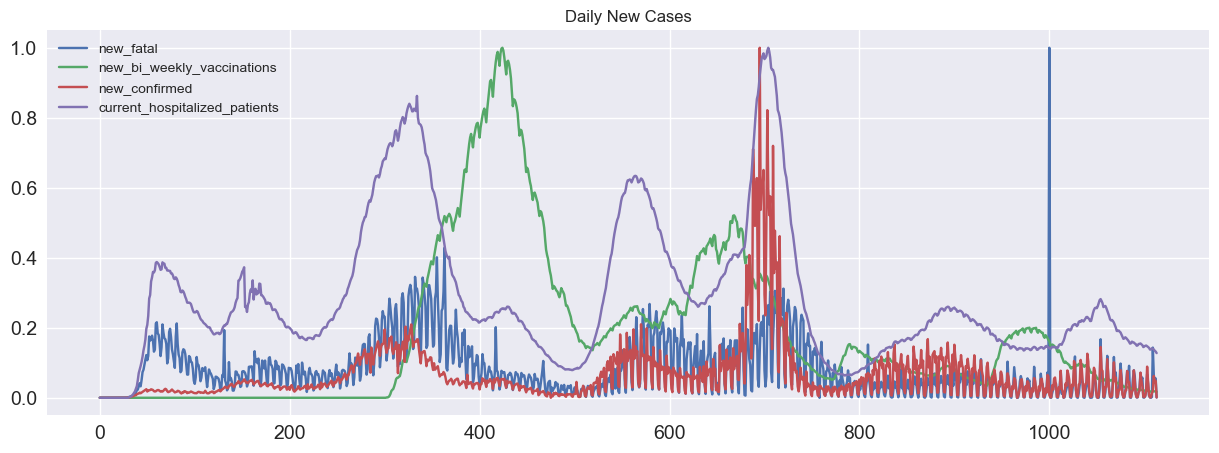

In [71]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
minmax.fit(train_df[most_important + ['new_confirmed']]) #.values.reshape(-1,1)


transformed_df = pd.DataFrame(columns=minmax.feature_names_in_, data = minmax.transform(train_df[most_important + ['new_confirmed']]))
transformed_df.plot(figsize=(15,5), y=['new_fatal', 'new_bi_weekly_vaccinations', 'new_confirmed', 'current_hospitalized_patients'], title= 'Daily New Cases', fontsize=14)

most_important

There was a major outlier in the new_fatal data. I was unsure of why this had occurred. However I decided to replace it with the second highest number, which was 5549.

In [72]:
train_df.new_fatal.nlargest(2)


date
2022-11-11    12718
2021-02-12     5449
Name: new_fatal, dtype: int32

In [73]:

train_df.loc[train_df.new_fatal.idxmax(), 'new_fatal'] = 5449

<Axes: title={'center': 'Daily New Cases'}>

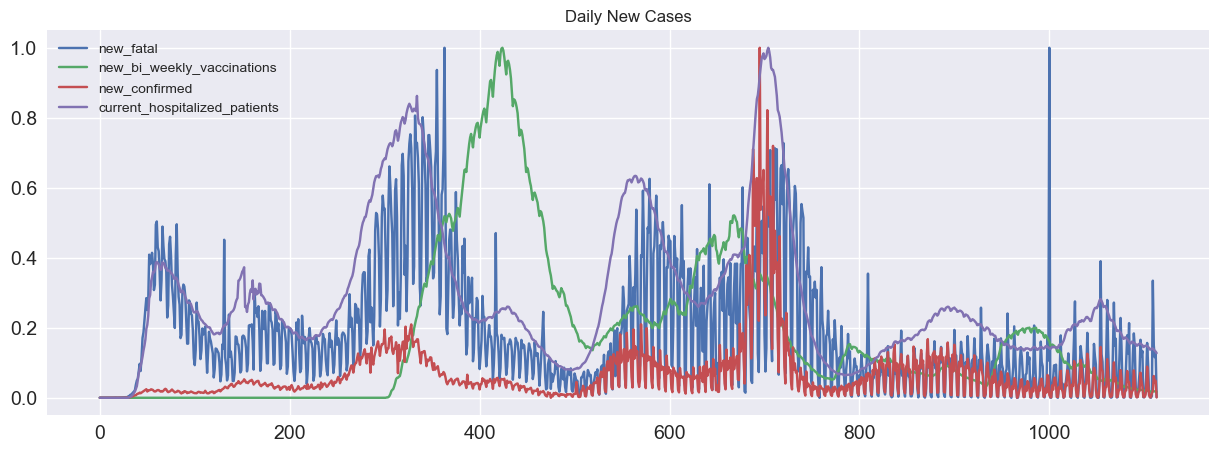

In [74]:
minmax_2 = MinMaxScaler()
minmax_2.fit(train_df[most_important + ['new_confirmed']]) #.values.reshape(-1,1)


transformed_df = pd.DataFrame(columns=minmax_2.feature_names_in_, data = minmax_2.transform(train_df[most_important + ['new_confirmed']]))
transformed_df.plot(figsize=(15,5), y=['new_fatal', 'new_bi_weekly_vaccinations', 'new_confirmed', 'current_hospitalized_patients'], title= 'Daily New Cases', fontsize=14)



In [75]:
most_important

['kap_mortality_rate',
 'month',
 'sig_recovery_rate',
 'excess_mortality_cumulative',
 'rho_transmission_rate',
 't/r_infection_period',
 'current_hospitalized_patients',
 'dayofweek',
 'new_fatal',
 'new_bi_weekly_vaccinations',
 'infected',
 'stringency_index']

### <a id='toc4_3_2_'></a>[Base Sarimax Model](#toc0_)

In [76]:
# Check if the training flag is set to True
if training:
    # # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= (3, 0, 2), 
                    seasonal_order =(2, 1, 1, 7),
                    suppress_warnings=True,
                    random_state=42))                   
                    ]
    
    pipeline = Pipeline(estimators) 

else:
    try:
        # If not training, then load the pre-trained model from disk
        model_5 = joblib.load('models/Exogenous ARIMA(3,0,2)(2,1,1)[7] intercept.pkl')
        print("model_5 loaded successfully")
    except:
        print("Error loading model_5")


0it [00:00, ?it/s]

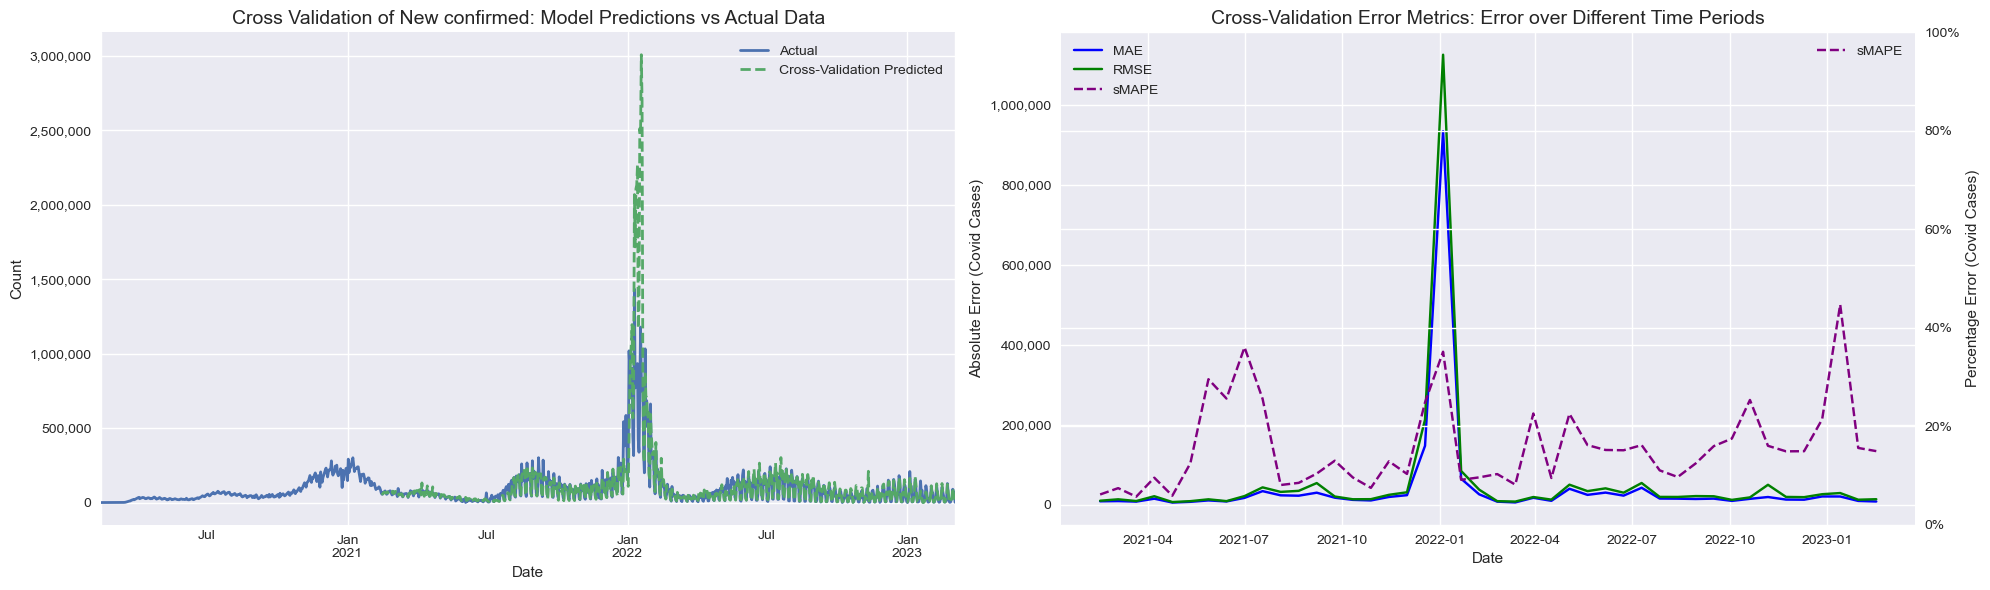

In [77]:
if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_5 = train_model(y_train, pipeline, window_cv, train_df[most_important])

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)



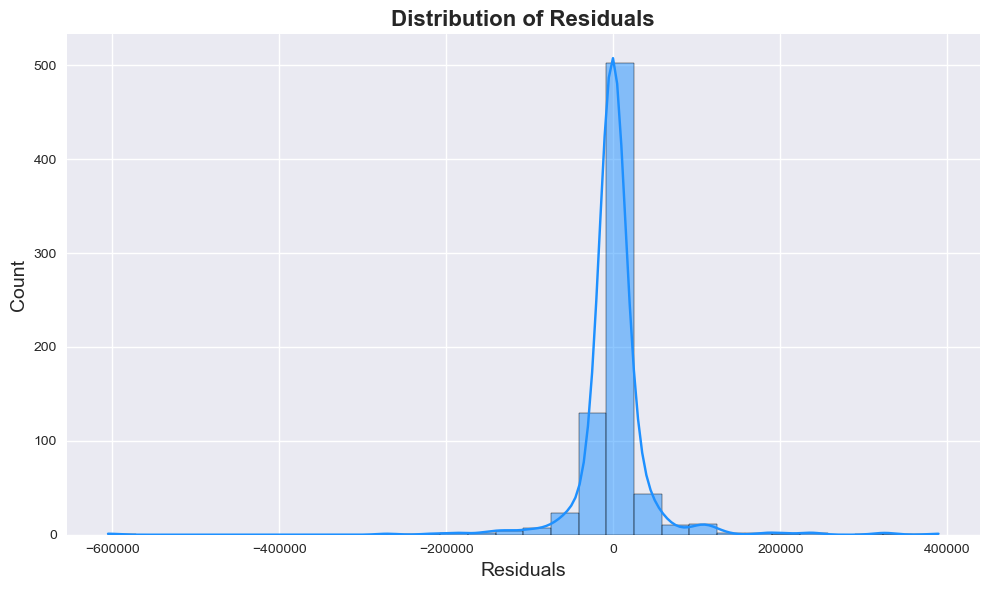

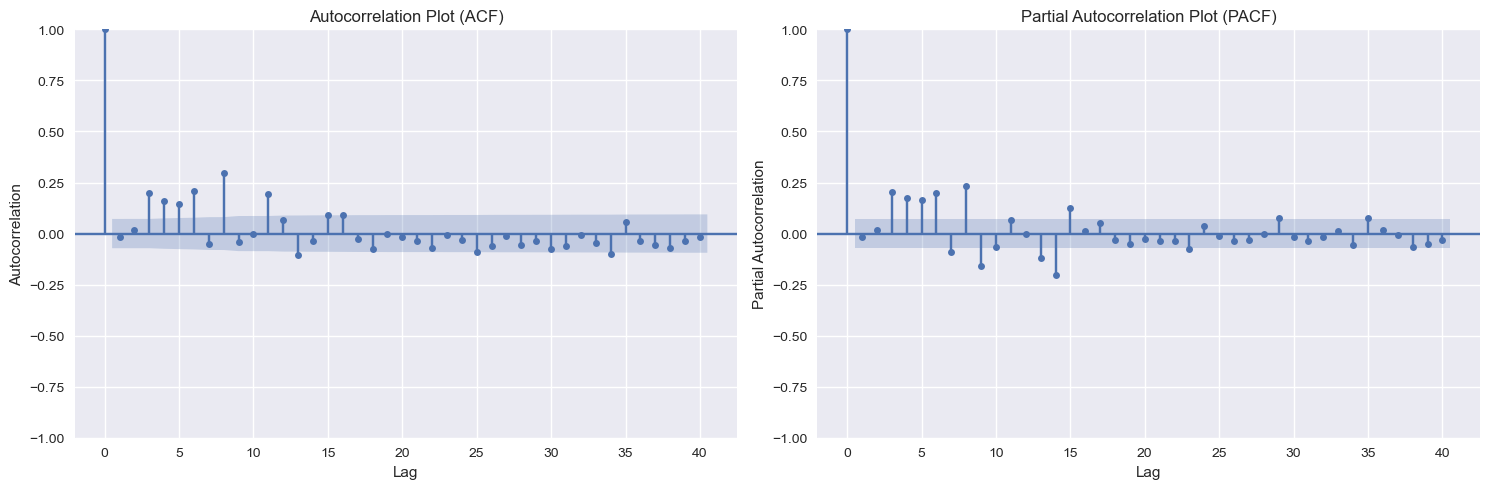

In [78]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_5, train_df[most_important])


In [79]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_5, test_df[most_important])


In [80]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Exogenous ' + str(model_5.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
    
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

In [81]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_5, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_5.summary()

Model pickled to models/Exogenous ARIMA(3,0,2)(2,1,1)[7] intercept.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1114
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 7)   Log Likelihood               -3492.562
Date:                             Fri, 11 Aug 2023   AIC                           7005.123
Time:                                     16:36:56   BIC                           7055.217
Sample:                                          0   HQIC                          7024.068
                                            - 1114                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0093      0.020      0.463      0.644      -0.030       0.049
ar.L1          0.0991      0.215      0.460      0.645      -0.323       0.521
ar.L2          0.8418      0.179      4.712      0.000       0.492       1.192
ar.L3          0.0269      0.045      0.595      0.552      -0.062       0.116
ma.L1          0.1654      0.213      0.775      0.438      -0.253       0.584
ma.L2         -0.5385      0.133     -4.062      0.000      -0.798      -0.279
ar.S.L7        0.1292      0.035      3.671      0.000       0.060       0.198
ar.S.L14       0.1826      0.032      5.657      0.000       0.119       0.246
ma.S.L7       -0.8314      0.028    -29.481      0.000      -0.887      -0.776
sigma2        32.0555      0.636     50.424      0.000      30.810      33.301
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5319.87
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='toc4_3_3_'></a>[Auto-Tuned SARIMAX Model](#toc0_)

In [82]:
# # Flag to determine if the model should be trained or loaded from disk


if training:
    if searching:
        # # # # If training is required:
    
        # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
        # and then automatically determines the best ARIMA order within the given range using auto_arima.
        estimators = [
        ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
        ("model", pm.auto_arima(y_train,
            train_df[prior_assumption],
            start_p=3,
            max_p=6,
            d=1,
            start_q=2,
            max_q=4,
            start_P=2,
            max_P=3,
            D=1,
            start_Q=1, 
            max_Q=3,
            m=7,
            seasonal=True, 
            trace=True,
            random_state=42,
            stepwise = False,
            n_jobs=-1))]

        pipeline = Pipeline(estimators)
    
    else:
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
        estimators = [
        ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
        ("model", pm.arima.ARIMA(order= (2, 1, 2), 
                        seasonal_order =(1, 1, 0, 7),
                        suppress_warnings=True,
                        with_intercept=False,
                        random_state=42))               
                        ]

        pipeline = Pipeline(estimators) 

else:
    # If not training, then load the pre-trained model from disk
    model_6 = joblib.load('models/Exogenous ARIMA(2,1,2)(1,1,0)[7].pkl')
    print("model_6 loaded successfully")




Best model:  ARIMA(2,1,2)(1,1,0)[7]          
Total fit time: 97.857 seconds


0it [00:00, ?it/s]

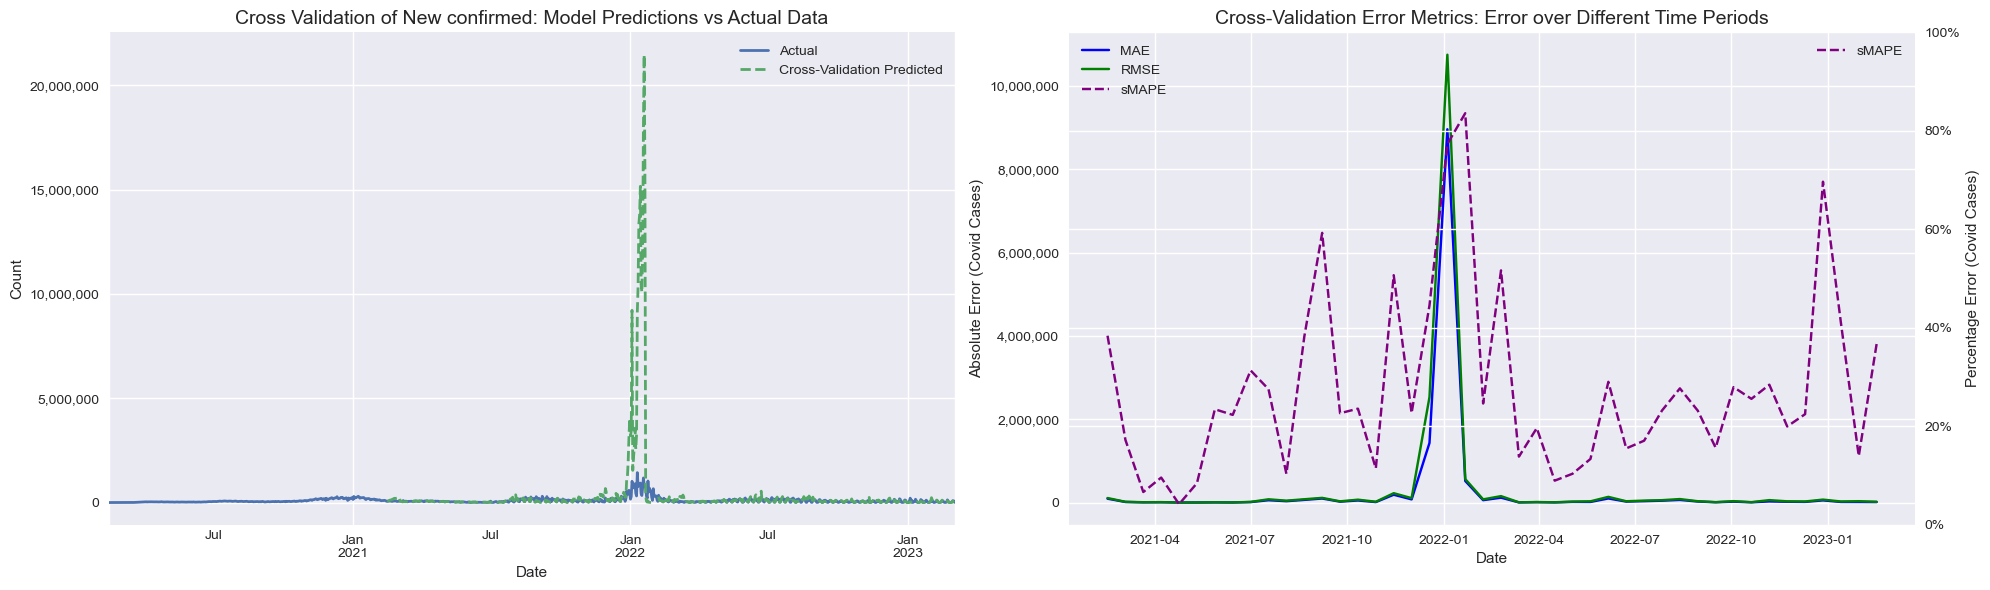

In [83]:
if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_6 = train_model(y_train, pipeline, window_cv, train_df[most_important])

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)



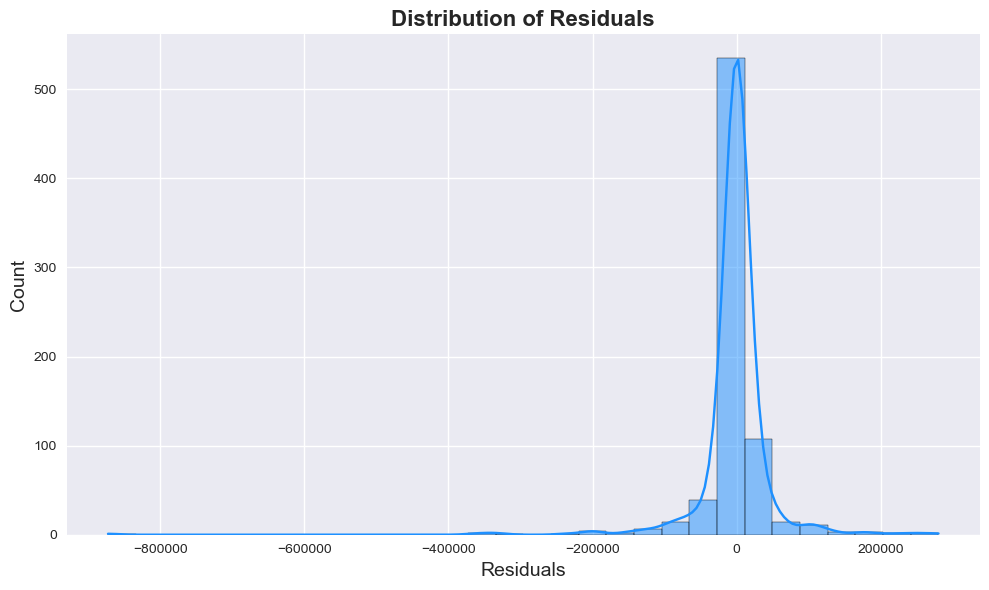

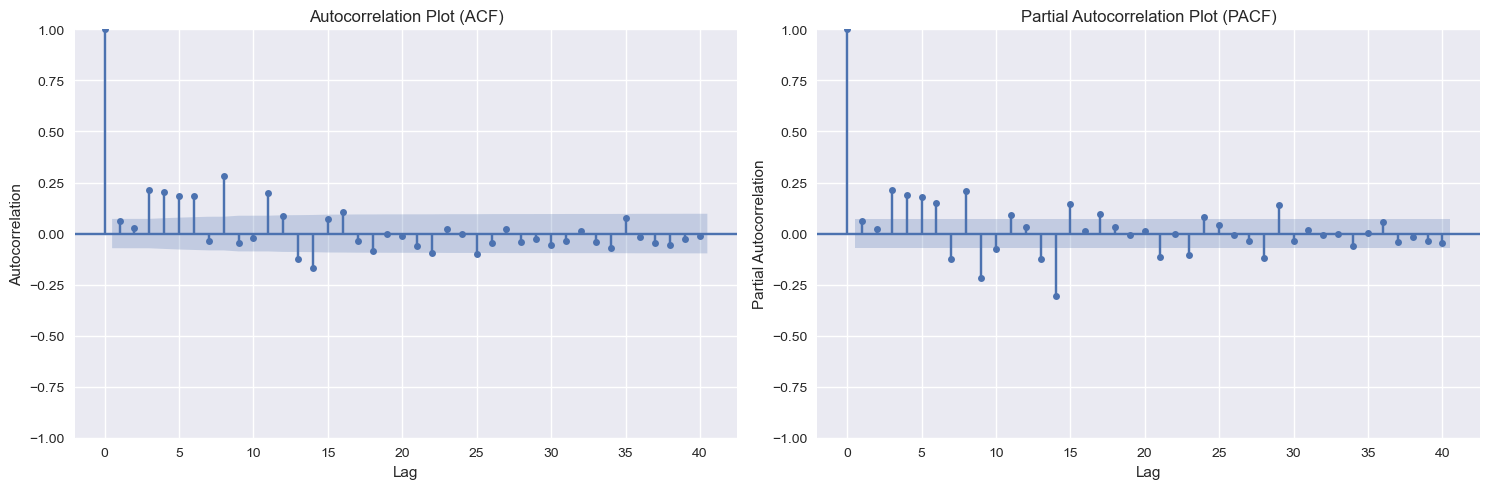

In [84]:
# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_6, train_df[most_important])


In [85]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_6, test_df[most_important])


In [86]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Exogenous ' + str(model_6.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()

in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

In [87]:
if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_6, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_6.summary()

Model pickled to models/Exogenous ARIMA(2,1,2)(1,1,0)[7].pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1114
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 7)   Log Likelihood               -3555.074
Date:                            Fri, 11 Aug 2023   AIC                           7122.149
Time:                                    16:43:23   BIC                           7152.200
Sample:                                         0   HQIC                          7133.514
                                           - 1114                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8391      0.203     -4.124      0.000      -1.238      -0.440
ar.L2         -0.0232      0.046     -0.503      0.615      -0.114       0.067
ma.L1          0.0663      0.200      0.331      0.741      -0.326       0.459
ma.L2         -0.5324      0.135     -3.950      0.000      -0.797      -0.268
ar.S.L7       -0.5123      0.017    -30.203      0.000      -0.546      -0.479
sigma2        36.1639      0.667     54.215      0.000      34.857      37.471
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4117.34
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.24   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## <a id='toc4_4_'></a>[Other Sarimax Modeling](#toc0_)

In [116]:
post_eda = ['derived_reproduction_rate', 'new_bi_weekly_vaccinations', 'current_intensive_care_patients', 'infected', 
                'kap_mortality_rate', 'dayofweek', 'new_fatal']

prior_assumption = ['stringency_index', 'derived_reproduction_rate', 'new_bi_weekly_vaccinations', 
                'current_hospitalized_patients', 'new_fatal'] # added infected, removed mortality_rate



In [117]:
# Check if the training flag is set to True
if training:
    # # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= (3, 0, 2), 
                    seasonal_order =(2, 1, 1, 7),
                    suppress_warnings=True,
                    random_state=42))                   
                    ]
    
    pipeline = Pipeline(estimators) 

else:
    try:
        # If not training, then load the pre-trained model from disk
        model_7 = joblib.load('models/Exogenous ARIMA(3,0,2)(2,1,1)[7] intercept.pkl')
        print("model_7 loaded successfully")
    except:
        print("Error loading model_7")


0it [00:00, ?it/s]

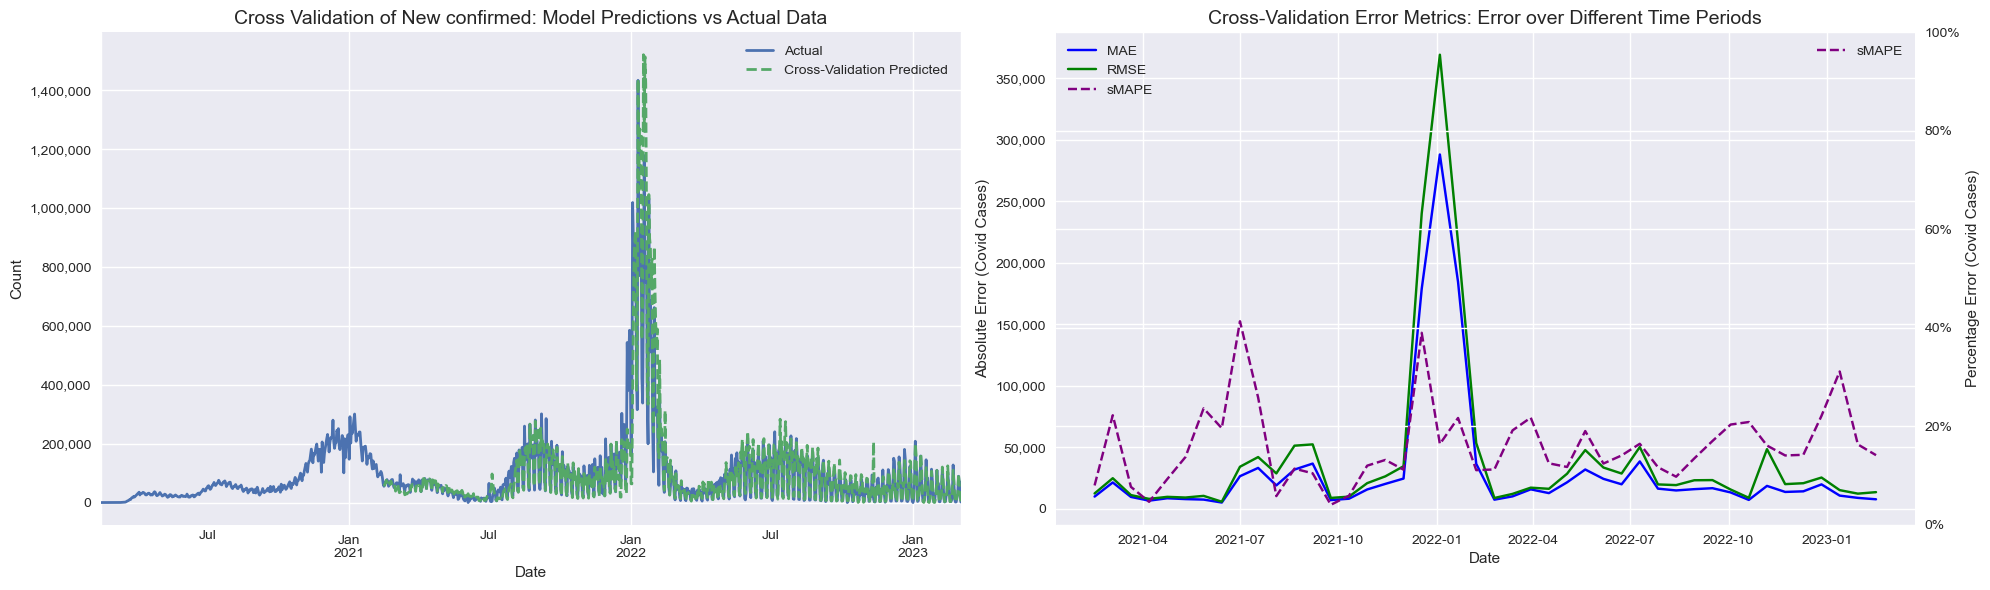

In [118]:
if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_7 = train_model(y_train, pipeline, window_cv, train_df[prior_assumption])

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)



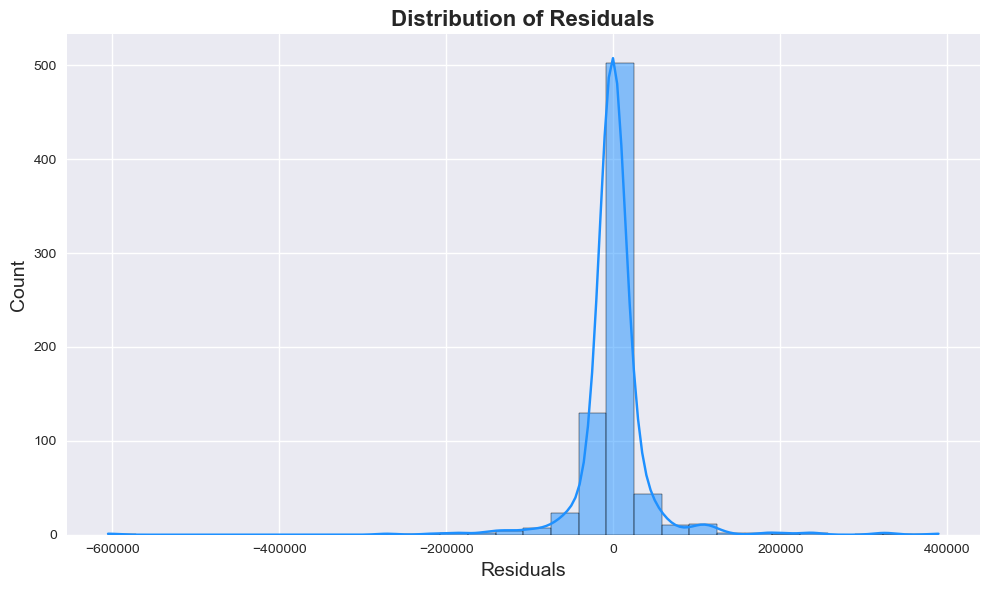

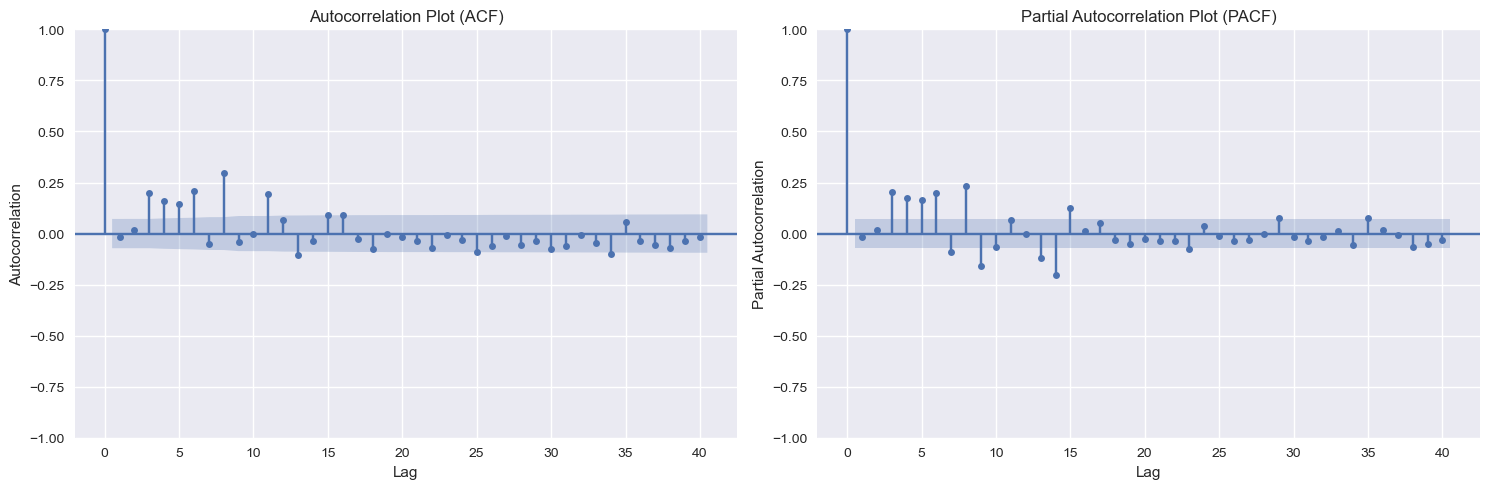

In [119]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_7, train_df[prior_assumption])


In [120]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_7, test_df[prior_assumption])


In [121]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Exogenous prior_assumption' + str(model_7.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
    
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

In [122]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_7, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_7.summary()

Model pickled to models/Exogenous prior_assumptionARIMA(3,0,2)(2,1,1)[7] intercept.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1114
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 7)   Log Likelihood               -3492.562
Date:                             Fri, 11 Aug 2023   AIC                           7005.123
Time:                                     17:03:39   BIC                           7055.217
Sample:                                          0   HQIC                          7024.068
                                            - 1114                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0093      0.020      0.463      0.644      -0.030       0.049
ar.L1          0.0991      0.215      0.460      0.645      -0.323       0.521
ar.L2          0.8418      0.179      4.712      0.000       0.492       1.192
ar.L3          0.0269      0.045      0.595      0.552      -0.062       0.116
ma.L1          0.1654      0.213      0.775      0.438      -0.253       0.584
ma.L2         -0.5385      0.133     -4.062      0.000      -0.798      -0.279
ar.S.L7        0.1292      0.035      3.671      0.000       0.060       0.198
ar.S.L14       0.1826      0.032      5.657      0.000       0.119       0.246
ma.S.L7       -0.8314      0.028    -29.481      0.000      -0.887      -0.776
sigma2        32.0555      0.636     50.424      0.000      30.810      33.301
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5319.87
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:

# def sarimax(ts,exo,all_param):
#     results = []
#     for param in all_param:
#         try:
#             mod = SARIMAX(ts,
#                         exog = exo,
#                         order=param[0],
#                         seasonal_order=param[1])
#             res = mod.fit()
#             results.append((res,res.aic,param))
#             print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
#         except Exception as e:
#             print(e)
#             continue
            
#     return results

# transformed_y = boxcox.fit_transform(y_train)
# transformed_y
# X_train

# if True:
#     boxcox = BoxCoxEndogTransformer(lmbda2=1e-6)
#     transformed_y = boxcox.fit_transform(y_train)

#     # set parameter range
#     p,d,q = range(0,5),range(0,2),range(0,4)
#     P,D,Q,s = range(0,3),range(0,2),range(0,3),[7]
#     # list of all parameter combos
#     pdq = list(product(p, d, q))
#     seasonal_pdq = list(product(P, D, Q, s))
#     all_param = list(product(pdq,seasonal_pdq))

#     all_res = sarimax(transformed_y, X_train, all_param)


In [124]:
# if True:
#     grid = pd.DataFrame(all_res).sort_values(by=2).rename(columns={0: 'drop', 1:'AIC',2:'Order'}).drop(columns='drop')

#     fig, ax = plt.subplots(figsize=(15,5))
#     grid.plot(x='Order', y='AIC', ax=ax, marker='o', linestyle='--', color='r')

#     # Setting axis labels
#     ax.set_xlabel("ARIMA Order")
#     ax.set_ylabel("AIC Value")
#     ax.set_title('Grid Search of ARIMA Order and AIC Value')

#     # Making x-ticks vertical
#     plt.xticks(rotation=90)

#     # Marking the lowest AIC with a vertical line
#     min_AIC_order = grid['AIC'].argmin()
#     ax.axvline(x=min_AIC_order, color='b', linestyle='--', label=f"Lowest AIC at {grid.loc[min_AIC_order, 'Order']}")
#     ax.legend()

#     # Setting y-axis limits
#     ax.set_ylim(26300, 27200)

#     plt.show()

In [125]:
# estimators = [
# ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
# ("model", pm.arima.ARIMA(order= (3, 0, 2), 
#                 seasonal_order =(2, 1, 1, 7),
#                 with_intercept=True,
#                 suppress_warnings=True,
#                 random_state=42))               
#                 ]

# pipeline = Pipeline(estimators) 

# # # # If not training, then load the pre-trained model from disk
# # model = joblib.load('models/Exogenous ARIMA(3,0,2)(2,1,1)[7] intercept.pkl')
# # print("model loaded successfully")


# run_analysis(y_train, y_test, pipeline, window_cv=window_cv, training=True, X_train=train_df[['t/k_mortality_period', 'current_hospitalized_patients',
#        'derived_reproduction_rate']], X_test=X_test[['t/k_mortality_period', 'current_hospitalized_patients',
#        'derived_reproduction_rate']])

# type_of_model = 'Exogenous Three'
# # Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
# model_name = f'{type_of_model} ' + str(pipeline.steps[-1][1]).strip()

# # Store evaluation metrics in their respective dictionaries
# if training:    
#     val_eval_holder[model_name] = val_scores.mean()
# # in_sample_eval_holder[model_name] = in_sample_scores
# out_of_sample_eval_holder[model_name] = test_scores

# # Display evaluation results

# if training:
#     display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))


## <a id='toc4_5_'></a>[Final Results and Evaluation](#toc0_)

In [126]:
if training:
    display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

# <a id='toc5_'></a>[Best COVID Forecaster](#toc0_)

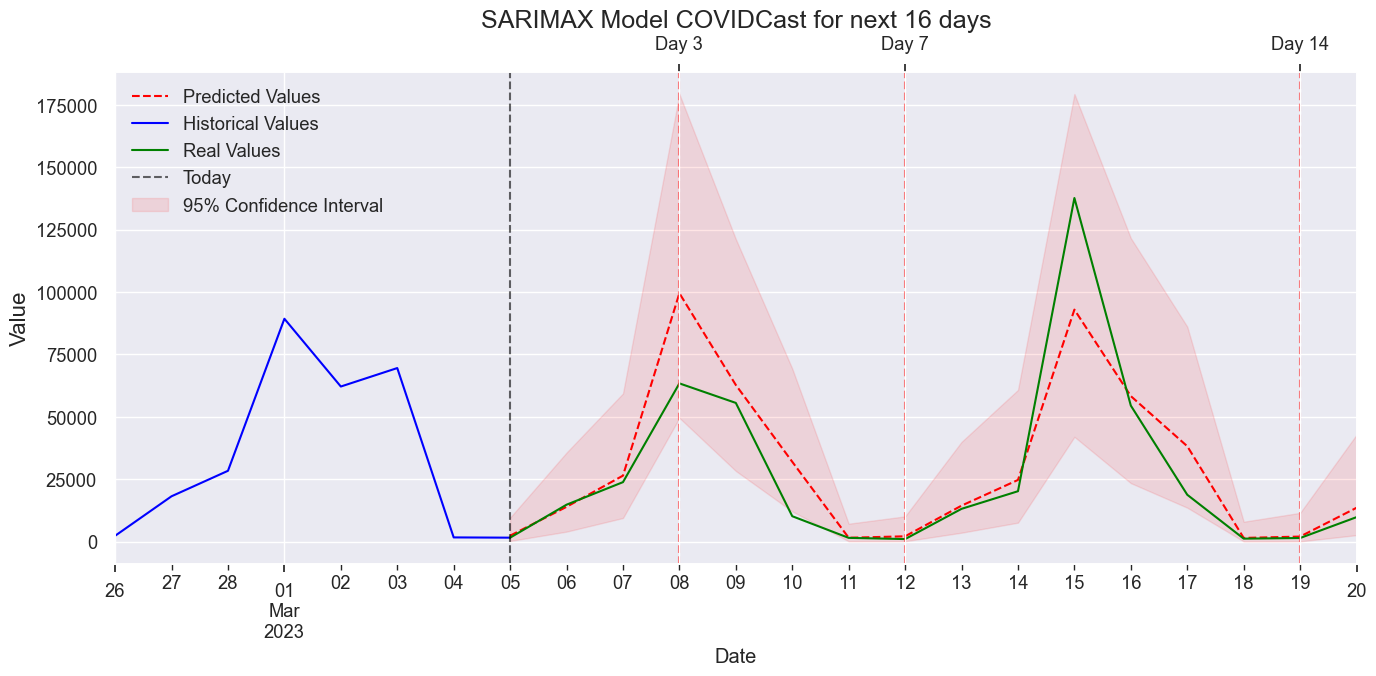

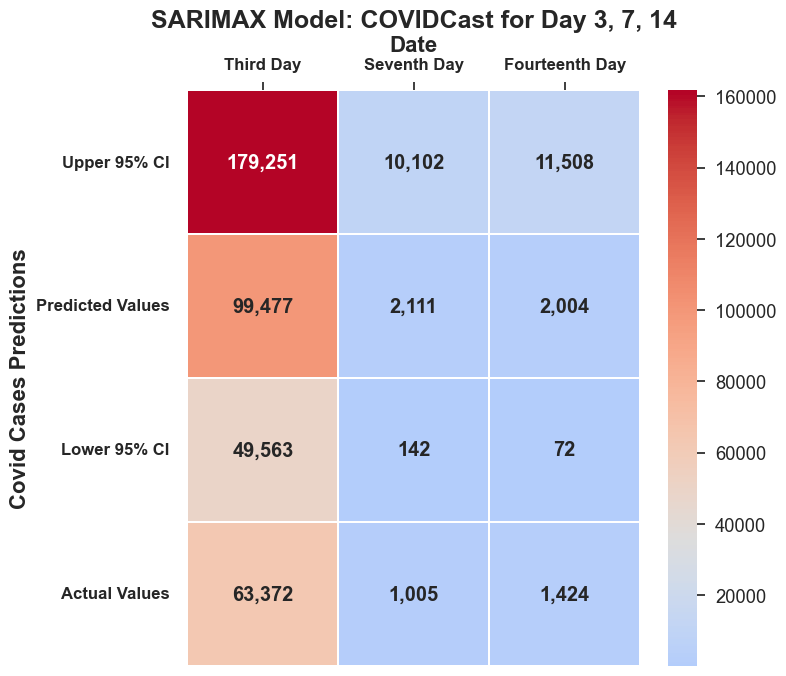

In [129]:
estimators = [
("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
("model", pm.arima.ARIMA(order= (3, 0, 2), 
                seasonal_order =(2, 1, 1, 7),
                suppress_warnings=True,
                random_state=42))               
                ]

pipeline = Pipeline(estimators) 

forecast_df = COVIDCastArima(pipeline, 
                            choose_your_date=choose_your_date, 
                            df=master_df, 
                            horizon=cutoff_period_prediction, 
                            target='new_confirmed', 
                            exogenous=prior_assumption)
